# Notebook for final training of models

Model combinations:
Features: Temperature+precipitation and basic energy balance
CV: Random 5-fold cross validation and blocking-by-glacier

Each of the four combinations above are trained with four different targets: Annual+seasonal, annual, summer and winter
Total of 16 model combinations.

## 0.1 Import libraries and define functions

In [1]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.inspection import permutation_importance
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from model_functions import select_variables
from model_functions import train_xgb_model
from plotting_functions import plot_gsearch_results
from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction
from plotting_functions import plot_prediction_subplot

In [3]:
def plot_prediction_subplot(y1, y2, data_type:str, ax, n_toplot=10**10, fold=False):
    """
    Plot model predictions y1 vs. actual observations y2 and show
    calculated error metrics.

    Parameters:
    y1 : np.array
        Predicted labels.
    y2 : np.array
        Actual labels.
    data_type : str
        Type of data, e.g. "Validation" or "Test".
    ax : array
        Axis object
    n_toplot : int
        Number of points to plot. 
    """
    
    from scipy.stats import gaussian_kde
    from sklearn.metrics import r2_score, mean_squared_error

    if fold:
        figsize=(5,5)
        fontsize=12
        s= 15
    else:
        figsize=(8,8)
        fontsize=16
        s= 20
    
    idxs = np.arange(len(y1))
    np.random.shuffle(idxs)

    y_max = 8#7 #max(max(y1), max(y2))[0] + 1
    y_min = -15#1 #min(min(y1), min(y2))[0] - 1
    
    y_expected = y1.reshape(-1)[idxs[:n_toplot]]
    y_predicted = y2.reshape(-1)[idxs[:n_toplot]]

    xy = np.vstack([y_expected, y_predicted])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]
    
    #fig = plt.figure(figsize=figsize)
    sc = ax.scatter(y_plt, ann_plt, c=z, s=s)
    sc.set_clim(0,0.2)
    #plt.tick_params(labelsize=14)
    plt.colorbar(sc,ax=ax,fraction=0.046) 
    lineStart = y_min
    lineEnd = y_max
    ax.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-')
    ax.set_title("Model Evaluation " + data_type, fontsize=fontsize)
    ax.set_ylabel('Modeled SMB (m.w.e)', fontsize=fontsize)
    ax.set_xlabel('Reference SMB (m.w.e)', fontsize=fontsize)
    ax.axvline(0.0, ls='-.', c='k')
    ax.axhline(0.0, ls='-.', c='k')
    ax.set_xlim(lineStart, lineEnd)
    ax.set_ylim(lineStart, lineEnd)
    ax.set_box_aspect(1)
    
    textstr = '\n'.join((
    r'$RMSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, squared=False), ),
    r'$MSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, squared=True), ),
    r'$R^2=%.2f$' % (r2_score(y_expected, y_predicted), )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    return ax
    #plt.show()

In [4]:
def get_prediction_per_season(X_train_s, y_train_s, splits_s, best_model, months=12):
    y_pred_list = []
    y_test_list = []
    i=0

    for train_index, test_index in splits_s:
        # Loops over n_splits iterations and gets train and test splits in each fold
        X_train, X_test = X_train_s[train_index], X_train_s[test_index]
        y_train, y_test = y_train_s[train_index], y_train_s[test_index]
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)

        indices = np.argwhere((X_test == months))[:,0]
        y_test_crop = y_test[indices]
        y_pred_crop = y_pred[indices]

        y_test_list.extend(y_test_crop)
        y_pred_list.extend(y_pred_crop)

        i=i+1

    # Arrays of predictions and observations for each fold
    y_test_all = np.hstack([*y_test_list])
    y_pred_all = np.hstack([*y_pred_list])

    return y_test_all, y_pred_all

In [70]:
def get_prediction_per_season_test(X_test, y_test, best_model, months=12):

    y_pred = best_model.predict(X_test)

    indices = np.argwhere((X_test == months))[:,0]
    y_test_crop = y_test[indices]
    y_pred_crop = y_pred[indices]

    return y_test_crop, y_pred_crop

In [5]:
def plot_prediction_per_season(y_test_all, y_pred_all, season='Annual'):
    
    figsize=(5,5)
    fontsize=16
    s= 20
    n_toplot=10**10
    
    idxs = np.arange(len(y_test_all))
    np.random.shuffle(idxs)

    y_max = 8#7 #max(max(y1), max(y2))[0] + 1
    y_min = -15#1 #min(min(y1), min(y2))[0] - 1
    
    y_expected = y_test_all.reshape(-1)[idxs[:n_toplot]]
    y_predicted = y_pred_all.reshape(-1)[idxs[:n_toplot]]

    xy = np.vstack([y_expected, y_predicted])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]
    
    fig = plt.figure(figsize=figsize, dpi=100)
    plt.title(season + " mass balance", fontsize=20)
    plt.ylabel('Modeled mass balance (m w.e)', fontsize=fontsize)
    plt.xlabel('Observed mass balance (m w.e)', fontsize=fontsize)
    sc = plt.scatter(y_plt, ann_plt, c=z, s=s)
    plt.clim(0,0.4)
    plt.tick_params(labelsize=14)
    #plt.colorbar(sc) 
    lineStart = y_min
    lineEnd = y_max
    plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-')
    plt.axvline(0.0, ls='-.', c='k')
    plt.axhline(0.0, ls='-.', c='k')
    plt.xlim(lineStart, lineEnd)
    plt.ylim(lineStart, lineEnd)
    plt.gca().set_box_aspect(1)
    
    textstr = '\n'.join((
    r'$RMSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, squared=False), ),
    r'$MSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, squared=True), ),
    r'$MAE=%.2f$' % (mean_absolute_error(y_expected, y_predicted), ),
    r'$R^2=%.2f$' % (r2_score(y_expected, y_predicted), )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.show()

In [6]:
# Plot permutation importance
def plot_permutation_importance(df_train_X_s, X_train_s, y_train_s, splits_s, best_model, max_features_plot = 10):

    fig, ax = plt.subplots(1,5, figsize=(30,10))
    a = 0    
    for train_index, test_index in splits_s:
        # Loops over n_splits iterations and gets train and test splits in each fold
        X_train, X_test = X_train_s[train_index], X_train_s[test_index]
        y_train, y_test = y_train_s[train_index], y_train_s[test_index]

        best_model.fit(X_train, y_train)
    
        result = permutation_importance(best_model, X_train, y_train, n_repeats=20, random_state=42, n_jobs=10)

        sorted_idx = result.importances_mean.argsort()
        labels = np.array(df_train_X_s.columns)[sorted_idx][-max_features_plot:]
    
        ax[a].boxplot(result.importances[sorted_idx].T[:,-max_features_plot:], vert=False, labels=labels)
        ax[a].set_title("Permutation Importance Fold " + str(a))

        a=a+1

    fig.show()

## 0.2 Import data and select test glaciers

In [7]:
# Specify filepaths and filenames.
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_annual = data[data['balance_netto'].notna()]
glacier_data_annual.reset_index(drop=True, inplace=True)

glacier_data_winter = data[data['balance_winter'].notna()]
glacier_data_winter.reset_index(drop=True, inplace=True)

glacier_data_summer = data[data['balance_summer'].notna()]
glacier_data_summer.reset_index(drop=True, inplace=True)

C:\Users\kasj\AppData\Local\Temp\ipykernel_1468\3172944082.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [56]:
# Manually select test glaciers (14 glaciers)
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2478, 2768, 2769, 3133, 3137, 3138, 3141]

# Get test dataset for each of annual, winter and summer mass balance
df_test_annual = glacier_data_annual[glacier_data_annual['BREID'].isin(test_glaciers)]
df_test_winter = glacier_data_winter[glacier_data_winter['BREID'].isin(test_glaciers)]
df_test_summer = glacier_data_summer[glacier_data_summer['BREID'].isin(test_glaciers)]
# 54 has 189 points
# 703 has 30 points
# 941 has 70 points
# 1280 has 71 points
# 2320 has 83 points
# 2478 has 89 points
# 2769 has 121 points
# 3133 has 38 points
# 3137 has 65 points
# 3138 has 6 points
# 3141 has 72 points

# Get training dataset for each of annual, winter and summer mass balance
df_train_annual = glacier_data_annual[~glacier_data_annual['BREID'].isin(test_glaciers)]
df_train_winter = glacier_data_winter[~glacier_data_winter['BREID'].isin(test_glaciers)]
df_train_summer = glacier_data_summer[~glacier_data_summer['BREID'].isin(test_glaciers)]

# Add number of months to each dataframe
df_train_annual['n_months']=12
df_train_winter['n_months']=8
df_train_summer['n_months']=6
df_test_annual['n_months']=12
df_test_winter['n_months']=8
df_test_summer['n_months']=6

print(f'Train/test annual: {len(df_train_annual)}/{len(df_test_annual)}')
print(f'Train/test winter: {len(df_train_winter)}/{len(df_test_winter)}')
print(f'Train/test summer: {len(df_train_summer)}/{len(df_test_summer)}')
print(f'All train/test: {len(df_train_annual)+len(df_train_winter)+len(df_train_summer)} / {len(df_test_annual)+len(df_test_winter)+len(df_test_summer)}')
print(f'Fraction train/test: {(len(df_train_annual)+len(df_train_winter)+len(df_train_summer)) / (len(df_test_annual)+len(df_test_winter)+len(df_test_summer)+len(df_train_annual)+len(df_train_winter)+len(df_train_summer))} / {(len(df_test_annual)+len(df_test_winter)+len(df_test_summer)) /(len(df_test_annual)+len(df_test_winter)+len(df_test_summer) + len(df_train_annual)+len(df_train_winter)+len(df_train_summer))}')
print(f'Total entries: {len(df_test_annual)+len(df_test_winter)+len(df_test_summer) + len(df_train_annual)+len(df_train_winter)+len(df_train_summer)}')


Train/test annual: 2845/1065
Train/test winter: 2752/1000
Train/test summer: 2901/1028
All train/test: 8498 / 3093
Fraction train/test: 0.7331550340781641 / 0.26684496592183593
Total entries: 11591


C:\Users\kasj\AppData\Local\Temp\ipykernel_1468\1108104880.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_annual['n_months']=12
C:\Users\kasj\AppData\Local\Temp\ipykernel_1468\1108104880.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_winter['n_months']=8
C:\Users\kasj\AppData\Local\Temp\ipykernel_1468\1108104880.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

## 0.3 Distribution of training and test datasets

Train mass balance: median 0.0, min -13.1, max 5.72.
Test mass balance: median -0.77, min -6.3, max 4.1.
Train altitude: mean 1344.6330404217927, min 190.0, max 2212.0.
Test altitude: mean 1240.7292957746479, min 390.0, max 2105.0.
Train mean temp: mean -1.8186689375713172, min -7.492487335205055, max 3.914905802408896.
Test mean temp: mean -1.3513429501433052, min -7.176125590006507, max 3.888141886393271.
Train prec sum: mean 0.06680563450651758, min 0.026136178523301197, max 0.132155250757932.
Test prec sum: mean 0.06316855986353319, min 0.026136178523301197, max 0.123711260966956.


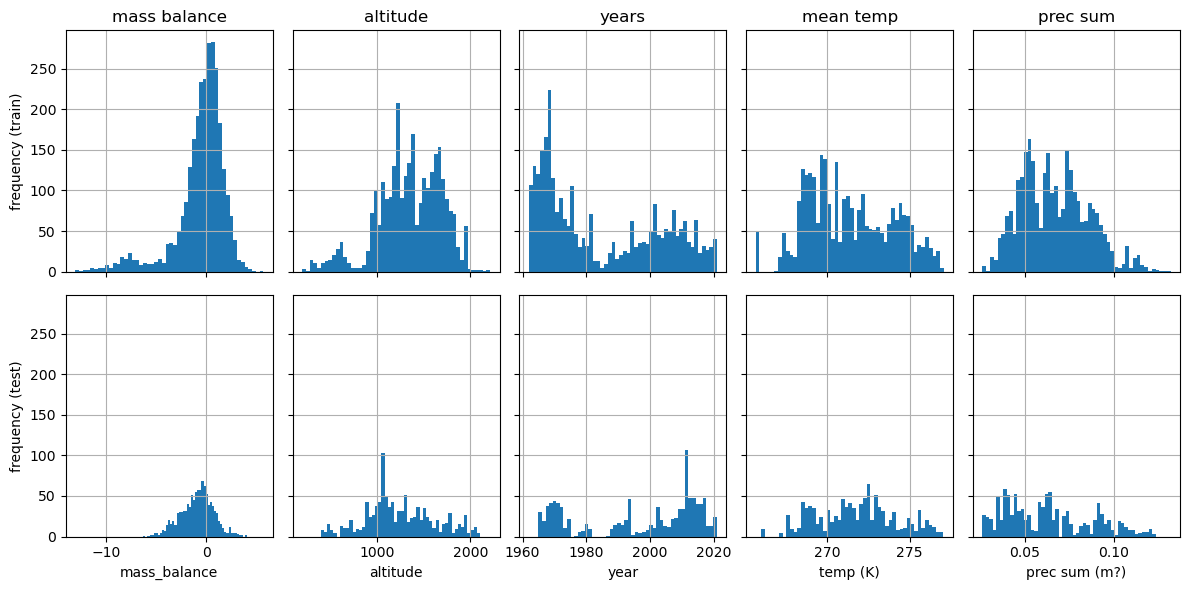

In [9]:
# Number of measurements by topography
temp_cols = ['t2m_oct','t2m_nov','t2m_dec','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
prec_cols = ['tp_oct','tp_nov','tp_dec','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']

f, ax = plt.subplots(2, 5, figsize=(12,6), sharey=True, sharex='col')
df_train_annual['balance_netto'].plot.hist(bins=50, ax=ax[0,0])
ax[0,0].set_title('mass balance')
ax[0,0].set_ylabel('frequency (train)')
df_train_annual['altitude'].plot.hist(bins=50, ax=ax[0,1])
ax[0,1].set_title('altitude')
df_train_annual['year'].plot.hist(bins=50, ax=ax[0,2])
ax[0,2].set_title('years')
df_train_annual[temp_cols].mean(axis=1).plot.hist(bins=50, ax=ax[0,3])
ax[0,3].set_title('mean temp')
df_train_annual[prec_cols].sum(axis=1).plot.hist(bins=50, ax=ax[0,4])
ax[0,4].set_title('prec sum')

df_test_annual['balance_netto'].plot.hist(bins=50, ax=ax[1,0])
ax[1,0].set_ylabel('frequency (test)')
ax[1,0].set_xlabel('mass_balance')
df_test_annual['altitude'].plot.hist(bins=50, ax=ax[1,1])
ax[1,1].set_xlabel('altitude')
df_test_annual['year'].plot.hist(bins=50, ax=ax[1,2])
ax[1,2].set_xlabel('year')
df_test_annual[temp_cols].mean(axis=1).plot.hist(bins=50, ax=ax[1,3])
ax[1,3].set_xlabel('temp (K)')
df_test_annual[prec_cols].sum(axis=1).plot.hist(bins=50, ax=ax[1,4])
ax[1,4].set_xlabel('prec sum (m?)')

for row in ax:
    for a in row:
        a.grid()

plt.tight_layout()

T_0 = 273.15
print(f"Train mass balance: median {df_train_annual['balance_netto'].median()}, min {df_train_annual['balance_netto'].min()}, max {df_train_annual['balance_netto'].max()}.")
print(f"Test mass balance: median {df_test_annual['balance_netto'].median()}, min {df_test_annual['balance_netto'].min()}, max {df_test_annual['balance_netto'].max()}.")
print(f"Train altitude: mean {df_train_annual['altitude'].mean()}, min {df_train_annual['altitude'].min()}, max {df_train_annual['altitude'].max()}.")
print(f"Test altitude: mean {df_test_annual['altitude'].mean()}, min {df_test_annual['altitude'].min()}, max {df_test_annual['altitude'].max()}.")
print(f"Train mean temp: mean {df_train_annual[temp_cols].mean().mean()-T_0}, min {df_train_annual[temp_cols].mean(axis=1).min()-T_0}, max {df_train_annual[temp_cols].mean(axis=1).max()-T_0}.")
print(f"Test mean temp: mean {df_test_annual[temp_cols].mean().mean()-T_0}, min {df_test_annual[temp_cols].mean(axis=1).min()-T_0}, max {df_test_annual[temp_cols].mean(axis=1).max()-T_0}.")
print(f"Train prec sum: mean {df_train_annual[prec_cols].sum(axis=1).mean()}, min {df_train_annual[prec_cols].sum(axis=1).min()}, max {df_train_annual[prec_cols].sum(axis=1).max()}.")
print(f"Test prec sum: mean {df_test_annual[prec_cols].sum(axis=1).mean()}, min {df_test_annual[prec_cols].sum(axis=1).min()}, max {df_test_annual[prec_cols].sum(axis=1).max()}.")

### 0.4 Training set-up

In [10]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 200, 300, 400, 500], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]}

## 1.0 Model 1: Temp+prec with 5-fold random CV

Features: Monthly temperature and precipitation <br>
CV-strategy: 5-fold random cross-validation <br>
Targets: <br>
1.1: Annual and seasonal observations <br>
1.2: Only annual mass balance <br>
1.3: Only summer mass balance <br>
1.4: Only winter mass balance <br>

### Prepare data

In [60]:
# Select features
base_cols = ['BREID','altitude','aspect','slope','altitude_climate']
temp_cols = ['t2m_oct','t2m_nov','t2m_dec','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
prec_cols = ['tp_oct','tp_nov','tp_dec','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']
label_cols = ['balance_netto']

# Select features for training
df_train_annual_clean = select_variables(df_train_annual, base_cols, temp_cols, prec_cols, ['balance_netto','n_months'])
df_train_winter_clean = select_variables(df_train_winter, base_cols, temp_cols, prec_cols, ['balance_winter','n_months'])
df_train_summer_clean = select_variables(df_train_summer, base_cols, temp_cols, prec_cols, ['balance_summer','n_months'])

# Rename target columns to same name
df_train_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_train_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_train_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)
var = ['t2m', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep', 'oct']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may']

for name in var:
    for mon in mon_summer:
        df_train_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        df_train_summer_clean[name+'_'+mon]= np.nan

# Combine all annual, winter and summer data in one dataframe
df_train_all = pd.concat([df_train_annual_clean, df_train_summer_clean, df_train_winter_clean])


C:\Users\kasj\AppData\Local\Temp\ipykernel_1468\2249480921.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
C:\Users\kasj\AppData\Local\Temp\ipykernel_1468\2249480921.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
C:\Users\kasj\AppData\Local\Temp\ipykernel_1468\2249480921.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [12]:
df_train_all.columns

Index(['BREID', 'altitude', 'aspect', 'slope', 'altitude_climate', 't2m_oct',
       't2m_nov', 't2m_dec', 't2m_jan', 't2m_feb', 't2m_mar', 't2m_apr',
       't2m_may', 't2m_jun', 't2m_jul', 't2m_aug', 't2m_sep', 'tp_oct',
       'tp_nov', 'tp_dec', 'tp_jan', 'tp_feb', 'tp_mar', 'tp_apr', 'tp_may',
       'tp_jun', 'tp_jul', 'tp_aug', 'tp_sep', 'balance', 'n_months'],
      dtype='object')

In [13]:
df_train_all.shape

(8498, 31)

In [61]:
# Prepare test dataset

# Select features for training
df_test_annual_clean = select_variables(df_test_annual, base_cols, temp_cols, prec_cols, ['balance_netto','n_months'])
df_test_winter_clean = select_variables(df_test_winter, base_cols, temp_cols, prec_cols, ['balance_winter','n_months'])
df_test_summer_clean = select_variables(df_test_summer, base_cols, temp_cols, prec_cols, ['balance_summer','n_months'])

# Rename target columns to same name
df_test_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_test_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_test_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)
for name in var:
    for mon in mon_summer:
        df_test_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        df_test_summer_clean[name+'_'+mon]= np.nan

# Combine all annual, winter and summer data in one dataframe
df_test_all = pd.concat([df_test_annual_clean, df_test_summer_clean, df_test_winter_clean])
df_test_all.reset_index(drop=True, inplace=True)

C:\Users\kasj\AppData\Local\Temp\ipykernel_1468\291277999.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
C:\Users\kasj\AppData\Local\Temp\ipykernel_1468\291277999.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
C:\Users\kasj\AppData\Local\Temp\ipykernel_1468\291277999.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [58]:
df_test_all.shape

(3093, 31)

### 1.1 Annual and seasonal mass balance

In [62]:
# Select features for training
df_train_X = df_train_all.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y = df_train_all[['balance']]

# Get arrays of features and targets
X_train, y_train = df_train_X.values, df_train_y.values

# Set random seed for split
rand_seed = 25

# Use five folds
kf = KFold(n_splits=5, shuffle=True, random_state=rand_seed)
splits = list(kf.split(X_train, y_train))

In [12]:
print(X_train.shape)
print(y_train.shape)

(8498, 29)
(8498, 1)


In [29]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
#cv_grid, best_model, cvl_scores = train_xgb_model(X_train, y_train, splits, param_ranges, 
#                                                  scorer='neg_mean_squared_error', return_train=True)

# Save cv-object
#joblib.dump(cv_grid, 'Models/Final_training/cv_rand_5fold_temp_prec_ann+seas_w_nmonths.pkl')

In [63]:
cv_grid = joblib.load('Models/Final_training/cv_rand_5fold_temp_prec_ann+seas_w_nmonths.pkl')
best_model = cv_grid.best_estimator_

C:\Users\kasj\AppData\Local\Temp\ipykernel_1468\962735944.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


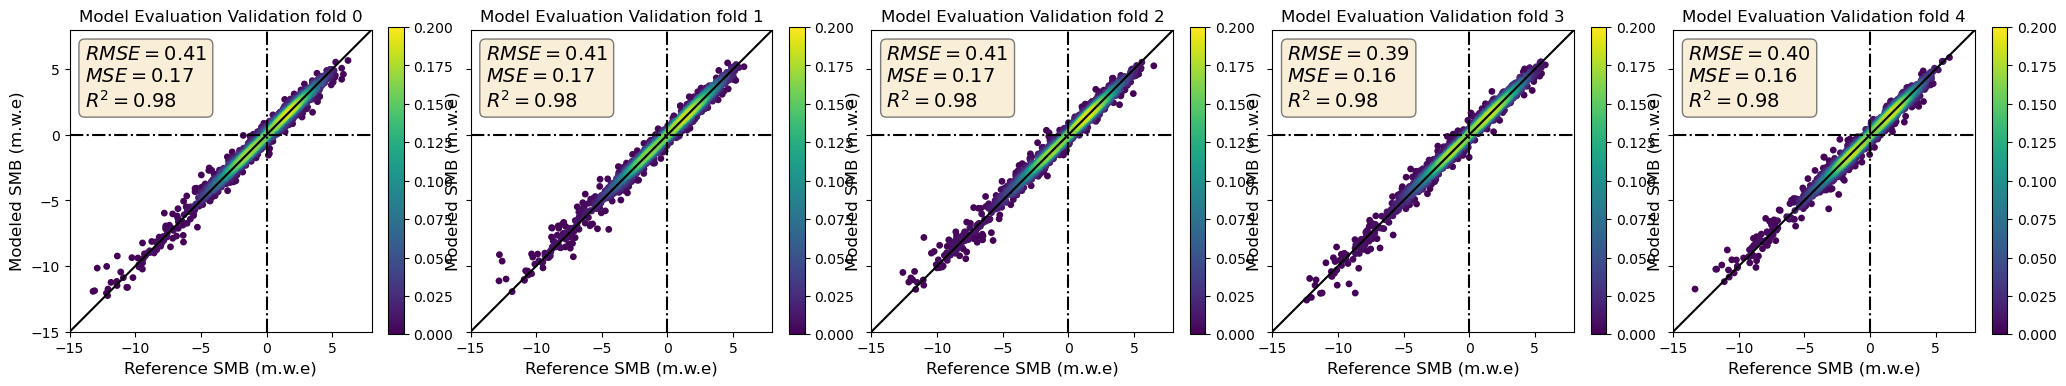

In [19]:
fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(25,25))
a = 0    
for train_index, test_index in splits:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train_, X_test_ = X_train[train_index], X_train[test_index]
    y_train_, y_test_ = y_train[train_index], y_train[test_index]
    best_model.fit(X_train_, y_train_)
    y_pred = best_model.predict(X_test_)

    title = 'Validation fold ' + str(a)

    plot_prediction_subplot(y_test_, y_pred, title, ax[a], n_toplot=5000, fold=True)

    a=a+1

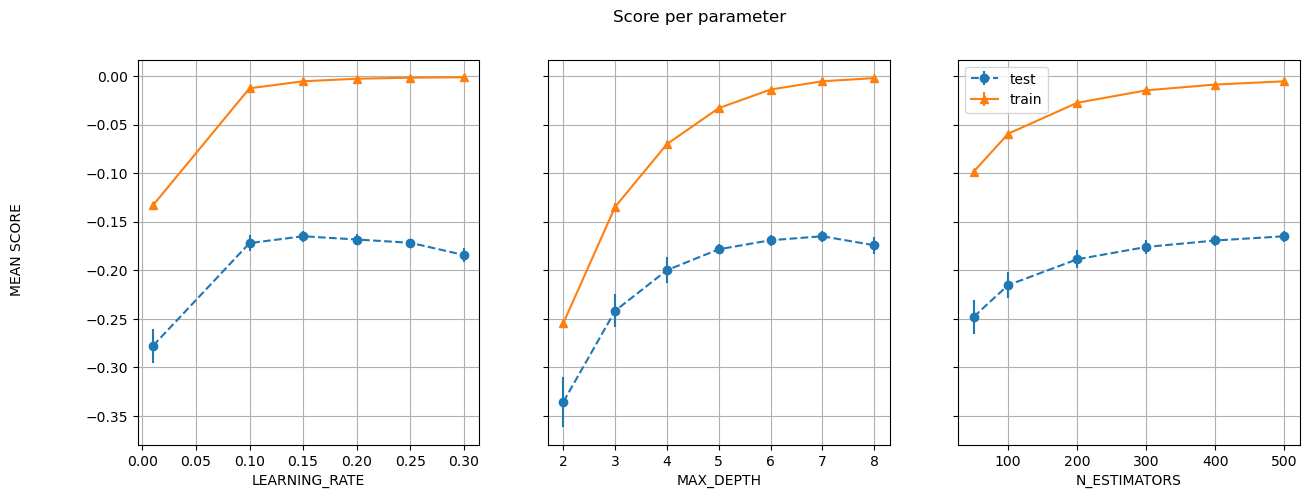

In [20]:
plot_gsearch_results(cv_grid)

C:\Users\kasj\AppData\Local\Temp\ipykernel_24204\2065068014.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


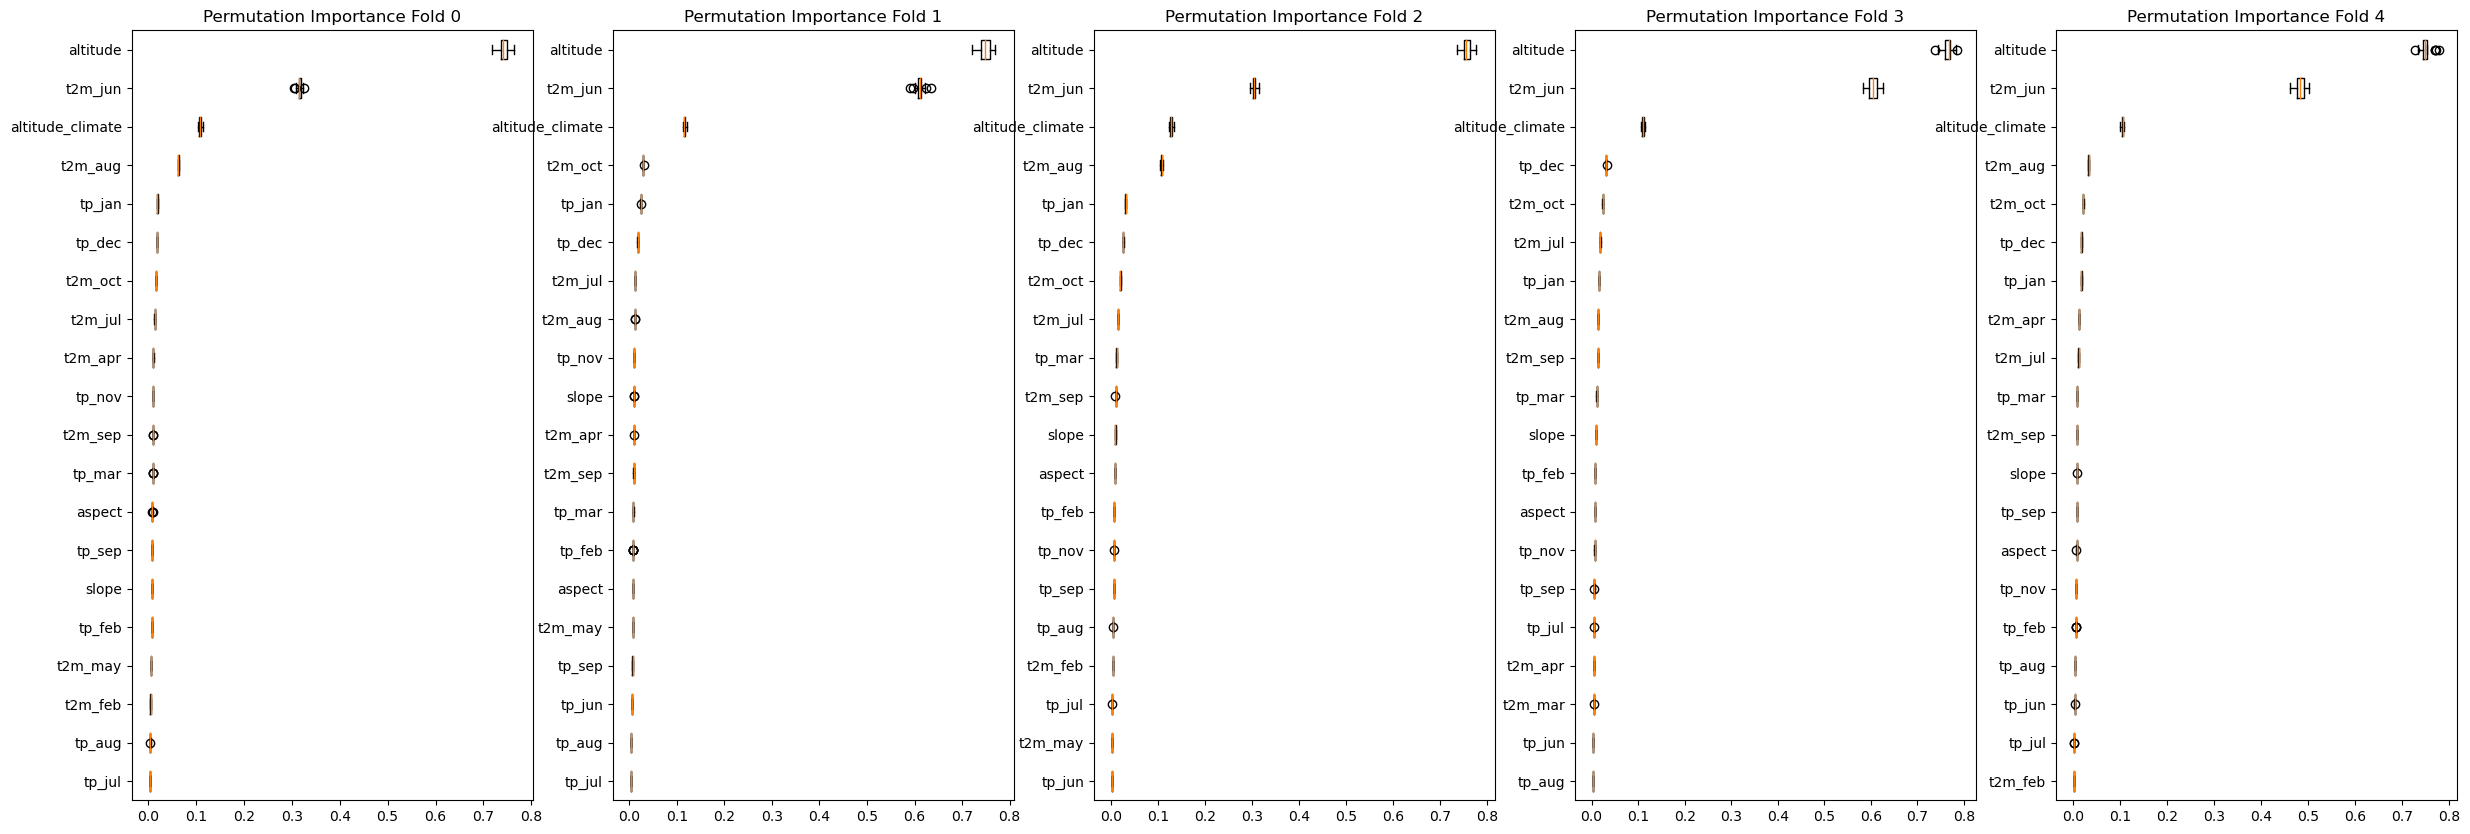

In [28]:
plot_permutation_importance(df_train_X, X_train, y_train, splits, best_model, max_features_plot = 20)

In [22]:
y_test_annual, y_pred_annual = get_prediction_per_season(X_train, y_train, splits, best_model, months=12)
y_test_winter, y_pred_winter = get_prediction_per_season(X_train, y_train, splits, best_model, months=8)
y_test_summer, y_pred_summer = get_prediction_per_season(X_train, y_train, splits, best_model, months=6)

print(y_test_annual.shape)
print(y_test_winter.shape)
print(y_test_summer.shape)

y_test_all = np.hstack((y_test_annual, y_test_winter, y_test_summer))
y_pred_all = np.hstack((y_pred_annual, y_pred_winter, y_pred_summer))

print(y_test_all.shape)
print(y_pred_all.shape)

(2845,)
(2752,)
(2901,)
(8498,)
(8498,)


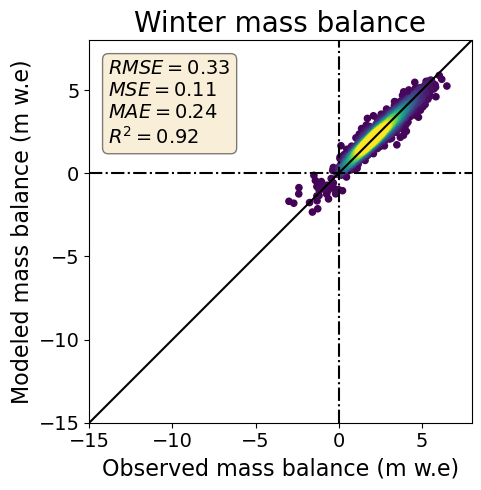

In [25]:
plot_prediction_per_season(y_test_winter, y_pred_winter, season='Winter')

In [31]:
#plot_prediction_per_fold(X_train, y_train, best_model, splits)

In [64]:
# Prepare test
# Select features for training
df_test_X = df_test_all.drop(['balance','BREID'], axis=1)

# Select labels for training
df_test_y = df_test_all[['balance']]

X_test, y_test = df_test_X.values, df_test_y.values


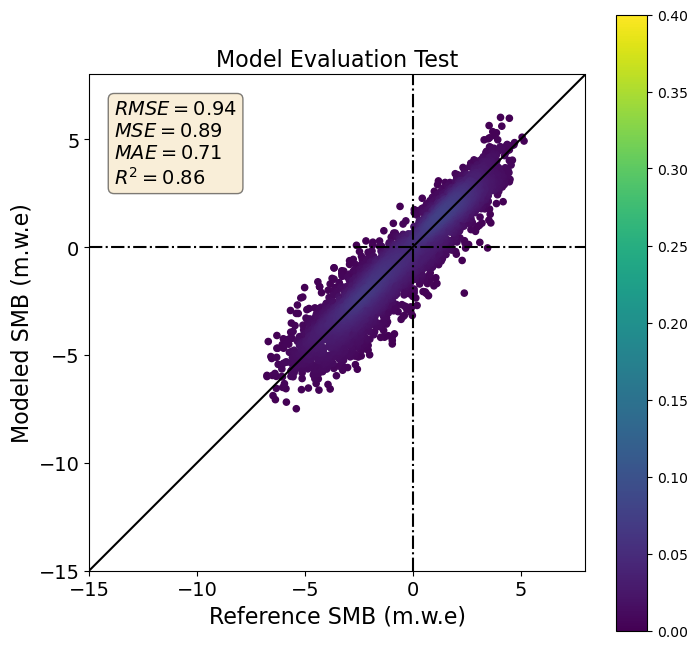

In [69]:
test_model = cv_grid.best_estimator_
test_model.fit(X_train, y_train)
y_pred_test = test_model.predict(X_test)
plot_prediction(y_test, y_pred_test, data_type='Test')

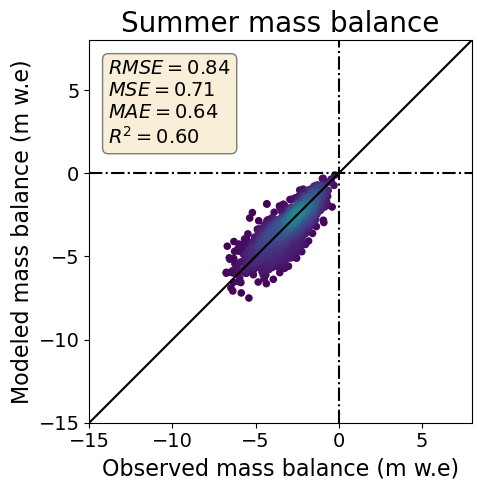

In [73]:
y_test_crop, y_pred_crop = get_prediction_per_season_test(X_test, y_test, test_model, months=6)
plot_prediction_per_season(y_test_crop, y_pred_crop, season='Summer')

### 1.2 Annual mass balance

In [90]:
# Select features for training
df_train_X = df_train_annual_clean.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y = df_train_annual_clean[['balance']]

# Get arrays of features and targets
X_train, y_train = df_train_X.values, df_train_y.values

# Set random seed for split
rand_seed = 25

# Use five folds
kf = KFold(n_splits=5, shuffle=True, random_state=rand_seed)
splits = list(kf.split(X_train, y_train))

# Train model
# Set return_train to False to inhibit return training scores. Default is True.
#cv_grid, best_model, cvl_scores = train_xgb_model(X_train, y_train, splits, param_ranges, 
#                                                  scorer='neg_mean_squared_error', return_train=True)

# Save cv-object
#joblib.dump(cv_grid, 'Models/Final_training/cv_rand_5fold_temp_prec_ann.pkl')


In [91]:
cv_grid = joblib.load('Models/Final_training/cv_rand_5fold_temp_prec_ann.pkl')
best_model = cv_grid.best_estimator_

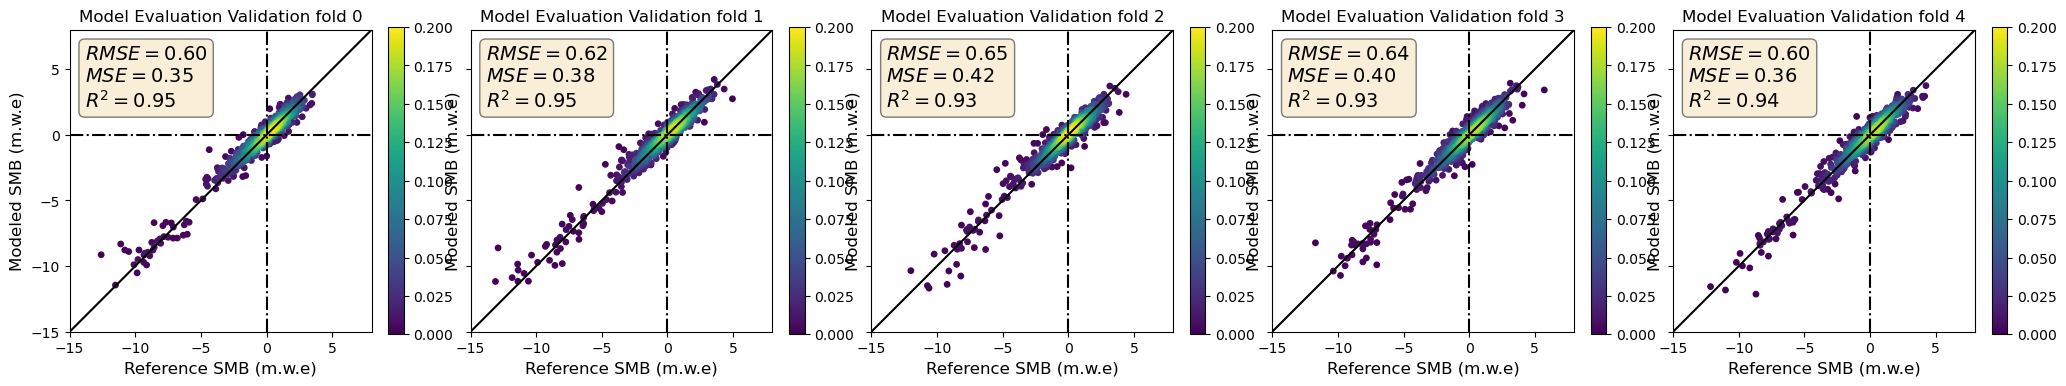

In [38]:
#plot_prediction_per_fold(X_train, y_train, best_model, splits)
fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(25,25))
a = 0    
for train_index, test_index in splits:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train_, X_test_ = X_train[train_index], X_train[test_index]
    y_train_, y_test_ = y_train[train_index], y_train[test_index]
    best_model.fit(X_train_, y_train_)
    y_pred = best_model.predict(X_test_)

    title = 'Validation fold ' + str(a)

    plot_prediction_subplot(y_test_, y_pred, title, ax[a], n_toplot=5000, fold=True)

    a=a+1

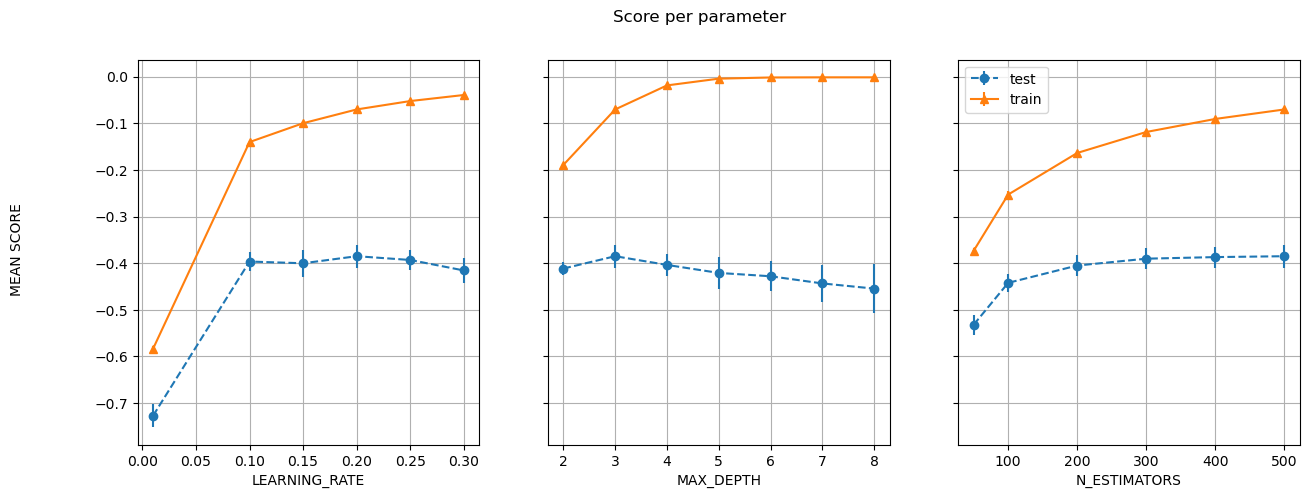

In [39]:
plot_gsearch_results(cv_grid)

In [92]:
# Prepare test
# Select features for training
df_test_X = df_test_annual_clean.drop(['balance','BREID'], axis=1)

# Select labels for training
df_test_y = df_test_annual_clean[['balance']]

X_test_annual, y_test_annual = df_test_X.values, df_test_y.values


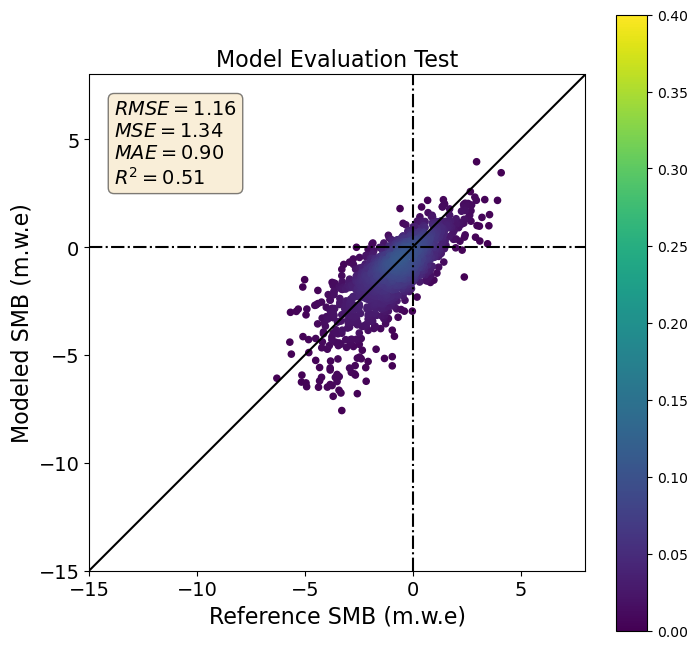

In [93]:
test_model = cv_grid.best_estimator_
test_model.fit(X_train, y_train)
y_pred_test_annual = test_model.predict(X_test_annual)
plot_prediction(y_test_annual, y_pred_test_annual, data_type='Test')

### 1.3 Summer mass balance

In [94]:
# Select features for training
df_train_X = df_train_summer_clean.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y = df_train_summer_clean[['balance']]

# Get arrays of features and targets
X_train, y_train = df_train_X.values, df_train_y.values

# Set random seed for split
rand_seed = 25

# Use five folds
kf = KFold(n_splits=5, shuffle=True, random_state=rand_seed)
splits = list(kf.split(X_train, y_train))

# Train model
# Set return_train to False to inhibit return training scores. Default is True.
#cv_grid, best_model, cvl_scores = train_xgb_model(X_train, y_train, splits, param_ranges, 
#                                                  scorer='neg_mean_squared_error', return_train=True)

# Save cv-object
#joblib.dump(cv_grid, 'Models/Final_training/cv_rand_5fold_temp_prec_summer.pkl')


In [41]:
X_train.shape

(2901, 29)

In [95]:
cv_grid = joblib.load('Models/Final_training/cv_rand_5fold_temp_prec_summer.pkl')
best_model = cv_grid.best_estimator_

In [46]:
#plot_prediction_per_fold(X_train, y_train, best_model, splits)

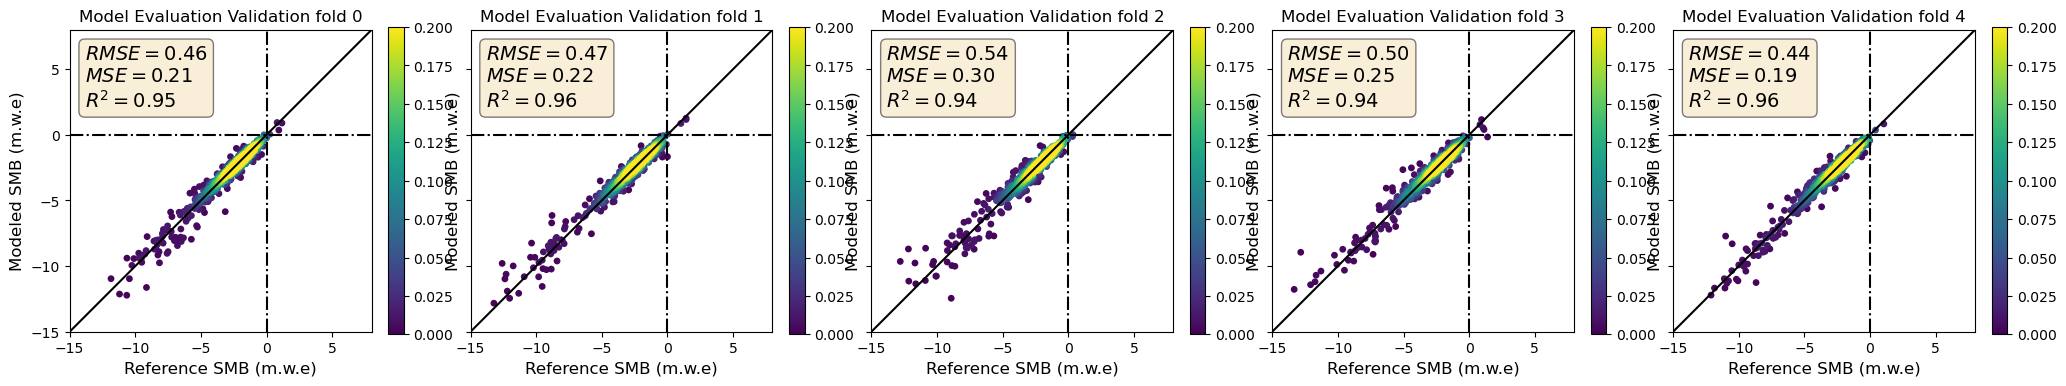

In [44]:
fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(25,25))
a = 0    
for train_index, test_index in splits:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train_, X_test_ = X_train[train_index], X_train[test_index]
    y_train_, y_test_ = y_train[train_index], y_train[test_index]
    best_model.fit(X_train_, y_train_)
    y_pred = best_model.predict(X_test_)

    title = 'Validation fold ' + str(a)

    plot_prediction_subplot(y_test_, y_pred, title, ax[a], n_toplot=5000, fold=True)

    a=a+1

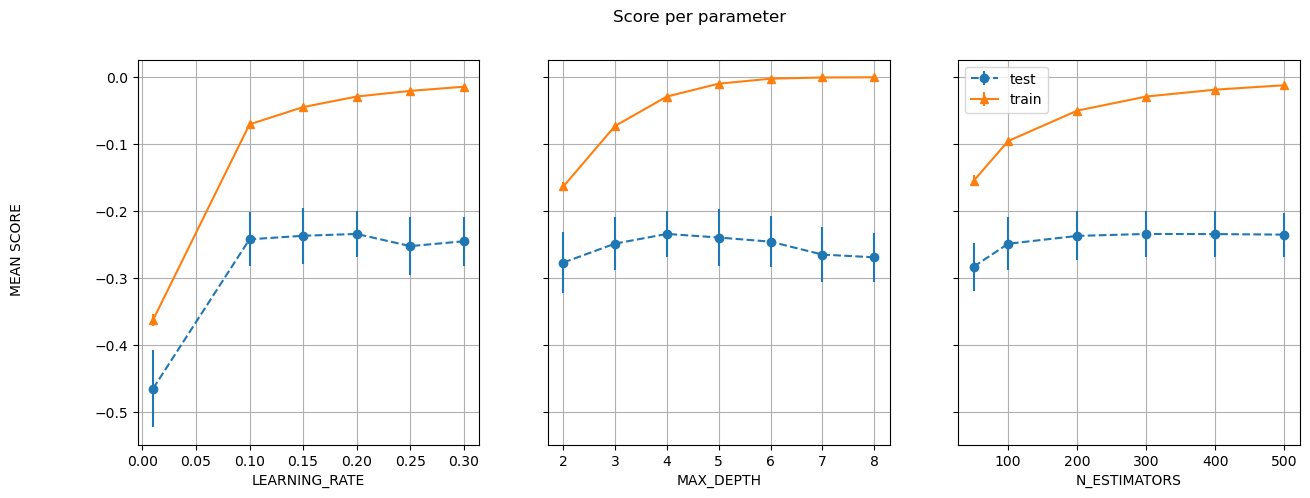

In [45]:
plot_gsearch_results(cv_grid)

In [98]:
# Prepare test
# Select features for training
df_test_X = df_test_summer_clean.drop(['balance','BREID'], axis=1)

# Select labels for training
df_test_y = df_test_summer_clean[['balance']]

X_test_summer, y_test_summer = df_test_X.values, df_test_y.values

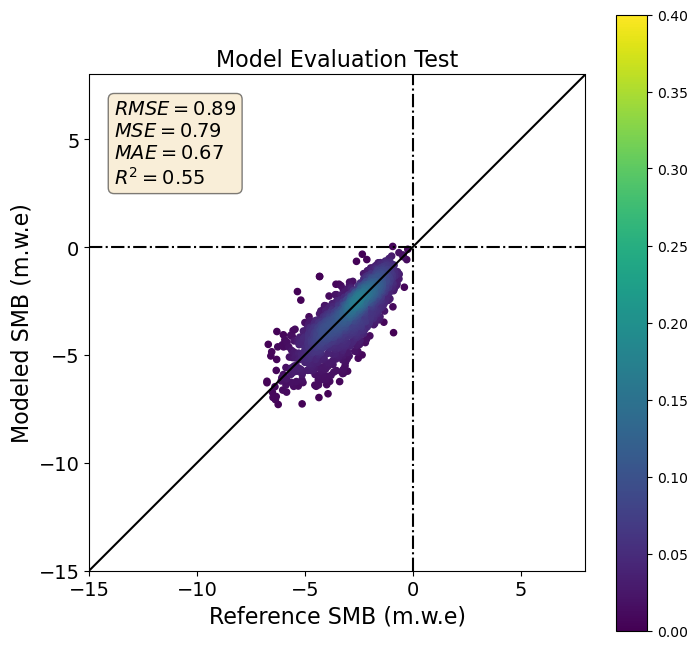

In [99]:
test_model = cv_grid.best_estimator_
test_model.fit(X_train, y_train)
y_pred_test_summer = test_model.predict(X_test_summer)
plot_prediction(y_test_summer, y_pred_test_summer, data_type='Test')

### 1.4 Winter mass balance

In [100]:
# Select features for training
df_train_X = df_train_winter_clean.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y = df_train_winter_clean[['balance']]

# Get arrays of features and targets
X_train, y_train = df_train_X.values, df_train_y.values

# Set random seed for split
rand_seed = 25

# Use five folds
kf = KFold(n_splits=5, shuffle=True, random_state=rand_seed)
splits = list(kf.split(X_train, y_train))

# Train model
# Set return_train to False to inhibit return training scores. Default is True.
#cv_grid, best_model, cvl_scores = train_xgb_model(X_train, y_train, splits, param_ranges, 
#                                                  scorer='neg_mean_squared_error', return_train=True)

# Save cv-object
#joblib.dump(cv_grid, 'Models/Final_training/cv_rand_5fold_temp_prec_winter.pkl')


In [49]:
X_train.shape

(2752, 29)

In [101]:
cv_grid = joblib.load('Models/Final_training/cv_rand_5fold_temp_prec_winter.pkl')
best_model = cv_grid.best_estimator_

In [52]:
#plot_prediction_per_fold(X_train, y_train, best_model, splits)

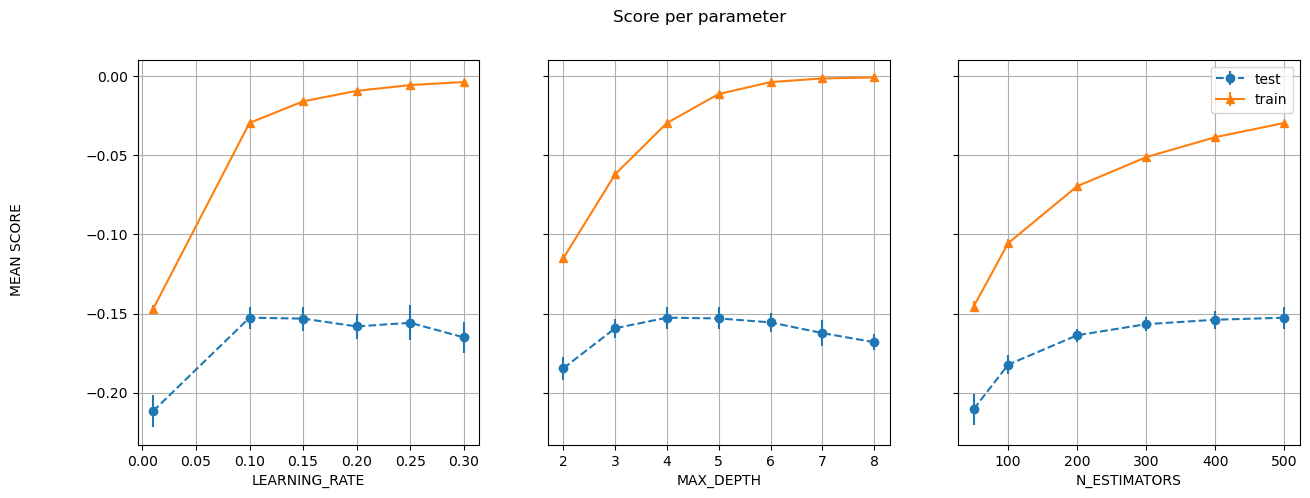

In [53]:
plot_gsearch_results(cv_grid)

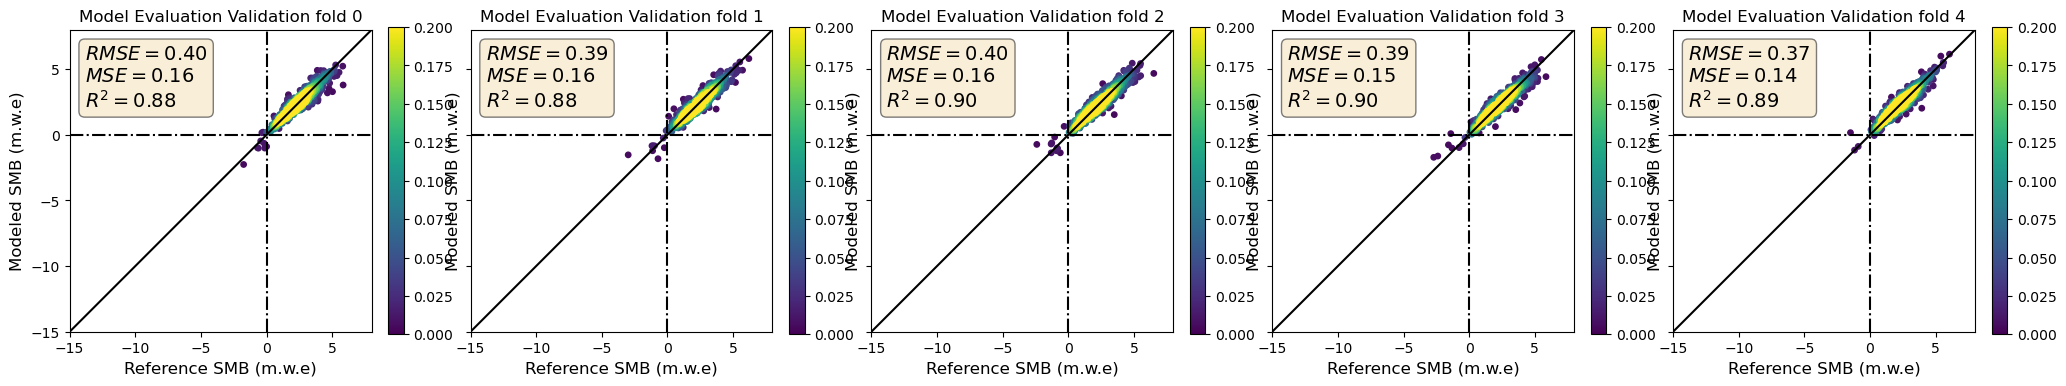

In [54]:
fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(25,25))
a = 0    
for train_index, test_index in splits:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train_, X_test_ = X_train[train_index], X_train[test_index]
    y_train_, y_test_ = y_train[train_index], y_train[test_index]
    best_model.fit(X_train_, y_train_)
    y_pred = best_model.predict(X_test_)

    title = 'Validation fold ' + str(a)

    plot_prediction_subplot(y_test_, y_pred, title, ax[a], n_toplot=5000, fold=True)

    a=a+1

In [102]:
# Prepare test
# Select features for training
df_test_X = df_test_winter_clean.drop(['balance','BREID'], axis=1)

# Select labels for training
df_test_y = df_test_winter_clean[['balance']]

X_test_winter, y_test_winter = df_test_X.values, df_test_y.values

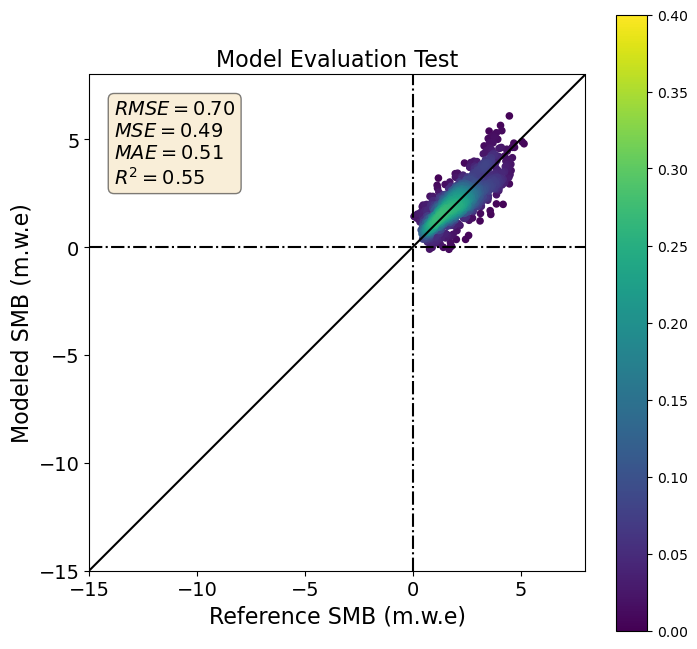

In [103]:
test_model = cv_grid.best_estimator_
test_model.fit(X_train, y_train)
y_pred_test_winter = test_model.predict(X_test_winter)
plot_prediction(y_test_winter, y_pred_test_winter, data_type='Test')

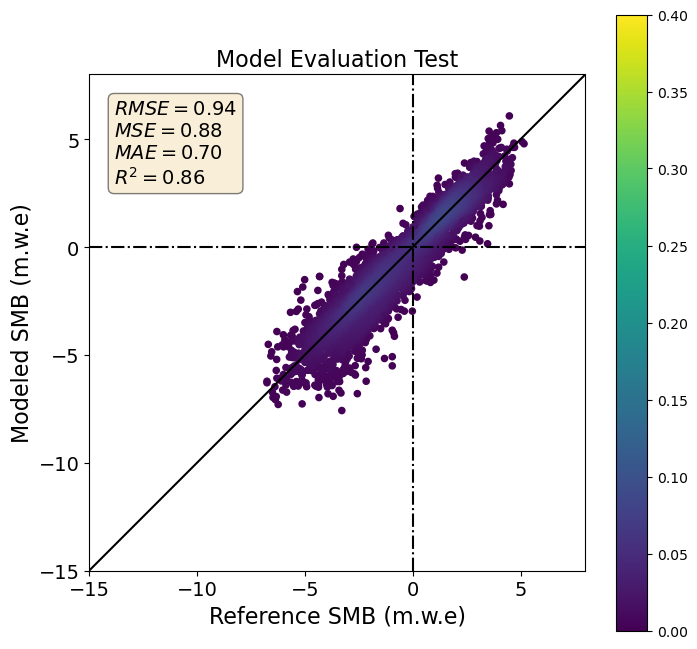

In [118]:
# Plot annual,, summer and winter together
y_test_all = np.hstack((y_test_annual[:,0], y_test_summer[:,0], y_test_winter[:,0]))
y_pred_test_all = np.hstack((y_pred_test_annual, y_pred_test_summer, y_pred_test_winter))
plot_prediction(y_test_all, y_pred_test_all, data_type='Test')

## 2.0 Model 2: Energy balance variables with 5-fold random CV
Features: ERA5-Land meteorological variables: tp, t2m, fal, ssrd, str, sshf, slhf <br>
CV-strategy: 5-fold random cross-validation <br>
Targets: <br>
2.1: Annual and seasonal observations <br>
2.2: Only annual mass balance <br>
2.3: Only summer mass balance <br>
2.4: Only winter mass balance <br>

### Prepare data

In [34]:
# Select columns to drop
cols = ['RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border','year', 'lat','lon', 'slope_factor']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']
dewpt_temp = ['d2m_oct','d2m_nov','d2m_dec','d2m_jan','d2m_feb','d2m_mar','d2m_apr','d2m_may','d2m_jun','d2m_jul','d2m_aug','d2m_sep']
surface_pressure = ['sp_oct','sp_nov','sp_dec','sp_jan','sp_feb','sp_mar','sp_apr','sp_may','sp_jun','sp_jul','sp_aug','sp_sep']
sol_rad_net = ['ssr_oct','ssr_nov','ssr_dec','ssr_jan','ssr_feb','ssr_mar','ssr_apr','ssr_may','ssr_jun','ssr_jul','ssr_aug','ssr_sep']
sol_therm_down = ['strd_oct','strd_nov','strd_dec','strd_jan','strd_feb','strd_mar','strd_apr','strd_may','strd_jun','strd_jul','strd_aug','strd_sep']
#sol_rad_down = ['ssrd_oct','ssrd_nov','ssrd_dec','ssrd_jan','ssrd_feb','ssrd_mar','ssrd_apr','ssrd_may','ssrd_jun','ssrd_jul','ssrd_aug','ssrd_sep']
u_wind = ['u10_oct','u10_nov','u10_dec','u10_jan','u10_feb','u10_mar','u10_apr','u10_may','u10_jun','u10_jul','u10_aug','u10_sep']
v_wind = ['v10_oct','v10_nov','v10_dec','v10_jan','v10_feb','v10_mar','v10_apr','v10_may','v10_jun','v10_jul','v10_aug','v10_sep']
#f_albedo = ['fal_oct','fal_nov','fal_dec','fal_jan','fal_feb','fal_mar','fal_apr','fal_may','fal_jun','fal_jul','fal_aug','fal_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo, 
                         dewpt_temp, surface_pressure, sol_rad_net, sol_therm_down, u_wind, v_wind] for y in x]

# Select features for training
df_train_annual_clean = df_train_annual.drop(drop_cols, axis=1)
df_train_winter_clean = df_train_winter.drop(drop_cols, axis=1)
df_train_summer_clean = df_train_summer.drop(drop_cols, axis=1)
df_train_annual_clean = df_train_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_train_winter_clean = df_train_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_train_summer_clean = df_train_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_train_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_train_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_train_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# df_train_X_... now contains columns of all chosen features and column with annual, winter or summer balance

# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)
var = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep', 'oct']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may']

for name in var:
    for mon in mon_summer:
        df_train_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        df_train_summer_clean[name+'_'+mon]= np.nan

# Combine all annual, winter and summer data in one dataframe
df_train_all = pd.concat([df_train_annual_clean, df_train_summer_clean, df_train_winter_clean])

### 2.1 Annual and seasonal mass balance

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Cross validation score:  -0.16210234711007016
Grid search best hyperparameters:  {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 500}
Cross validation scores per fold:  [-0.1713105  -0.16677355 -0.16819219 -0.15232806 -0.15190743]
Mean cross validation score:  -0.16210234711007016
Standard deviation:  0.008284555436029638


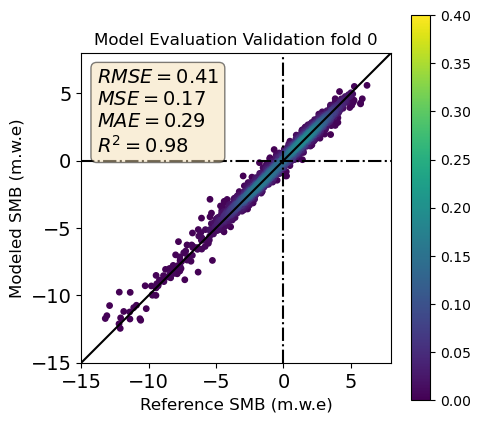

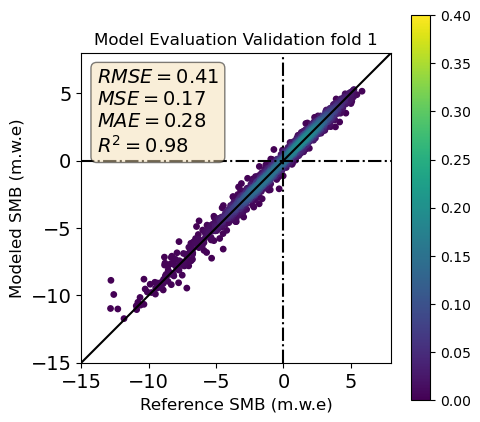

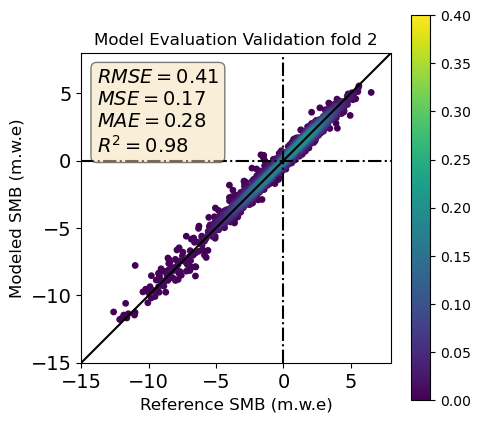

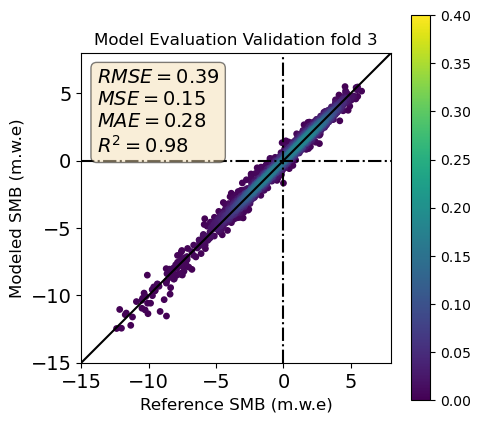

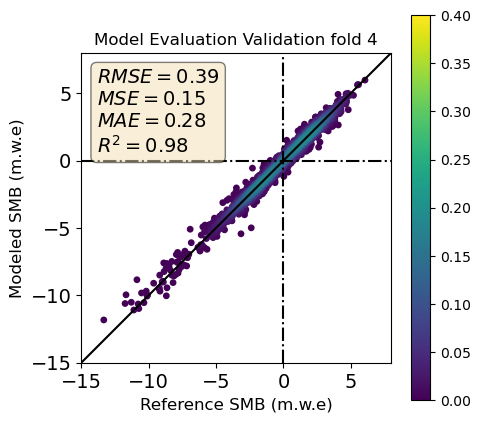

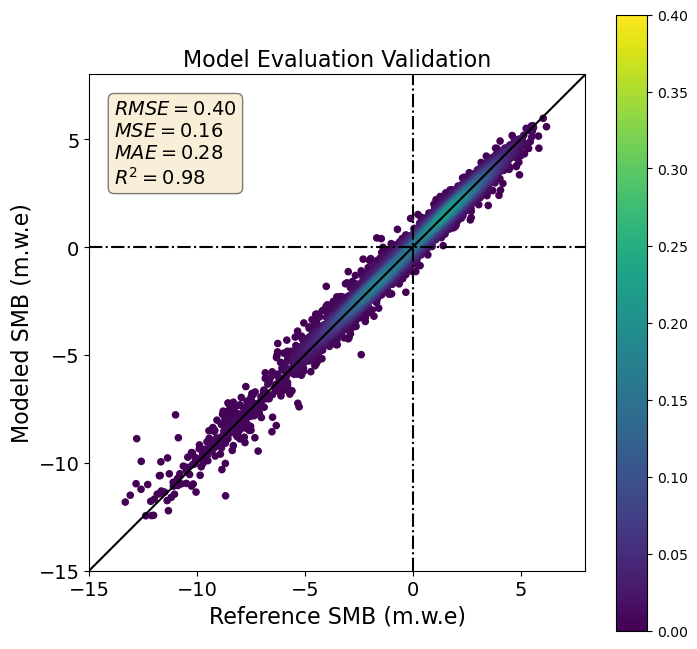

['Models/Final_training/cv_rand_5fold_all_climate_ann+seas.pkl']

In [39]:
# Select features for training
df_train_X = df_train_all.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y = df_train_all[['balance']]

# Get arrays of features and targets
X_train, y_train = df_train_X.values, df_train_y.values

# Set random seed for split
rand_seed = 25

# Use five folds
kf = KFold(n_splits=5, shuffle=True, random_state=rand_seed)
splits = list(kf.split(X_train, y_train))

# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 200, 300, 400, 500], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]}

# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train, y_train, splits, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

# Save cv-object
joblib.dump(cv_grid, 'Models/Final_training/cv_rand_5fold_all_climate_ann+seas.pkl')


### 2.2 Annual mass balance

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Cross validation score:  -0.3963268853811051
Grid search best hyperparameters:  {'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 500}
Cross validation scores per fold:  [-0.36019605 -0.45784567 -0.40030433 -0.36895398 -0.39433439]
Mean cross validation score:  -0.3963268853811051
Standard deviation:  0.034231749968559495


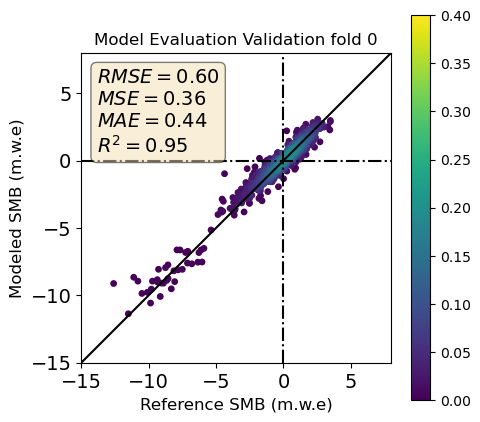

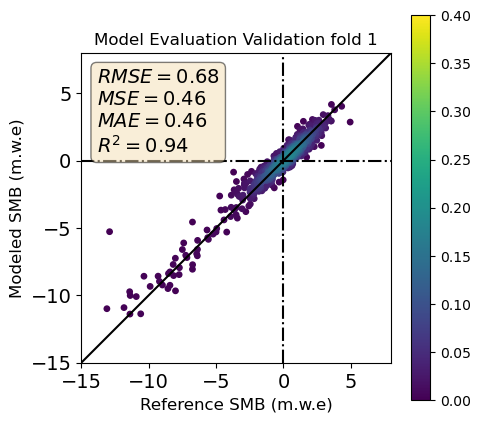

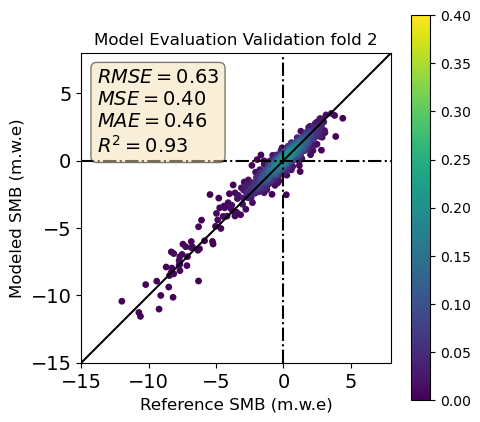

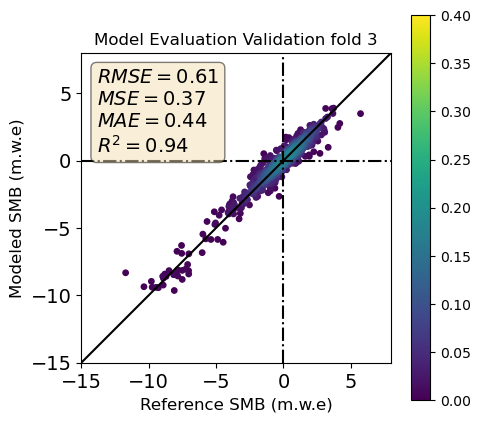

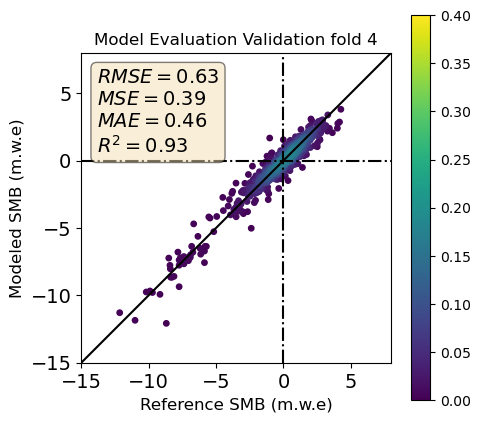

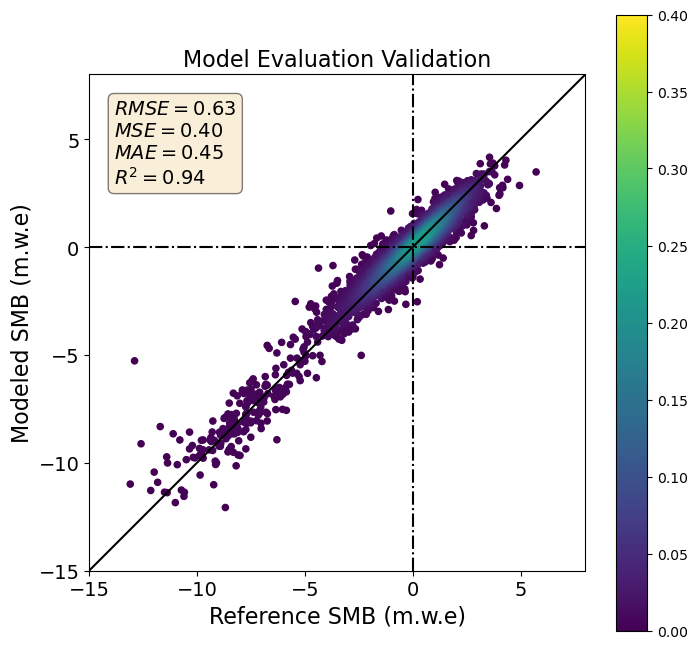

['Models/Final_training/cv_rand_5fold_all_climate_annual.pkl']

In [40]:
# Select features for training
df_train_X = df_train_annual_clean.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y = df_train_annual_clean[['balance']]

# Get arrays of features and targets
X_train, y_train = df_train_X.values, df_train_y.values

# Set random seed for split
rand_seed = 25

# Use five folds
kf = KFold(n_splits=5, shuffle=True, random_state=rand_seed)
splits = list(kf.split(X_train, y_train))

# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 200, 300, 400, 500], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]}

# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train, y_train, splits, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

# Save cv-object
joblib.dump(cv_grid, 'Models/Final_training/cv_rand_5fold_all_climate_annual.pkl')

### 2.3 Summer mass balance

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Cross validation score:  -0.23240138122042975
Grid search best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}
Cross validation scores per fold:  [-0.21227662 -0.2266592  -0.29443165 -0.23650817 -0.19213126]
Mean cross validation score:  -0.23240138122042975
Standard deviation:  0.03442173942989992


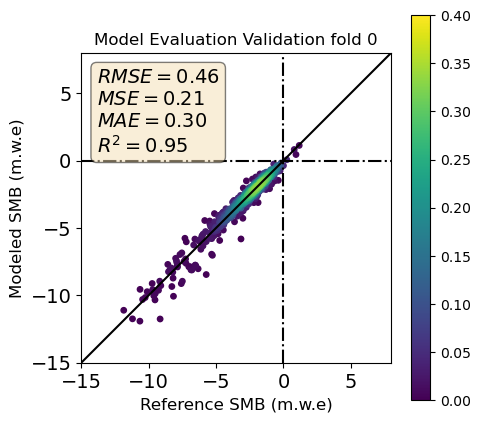

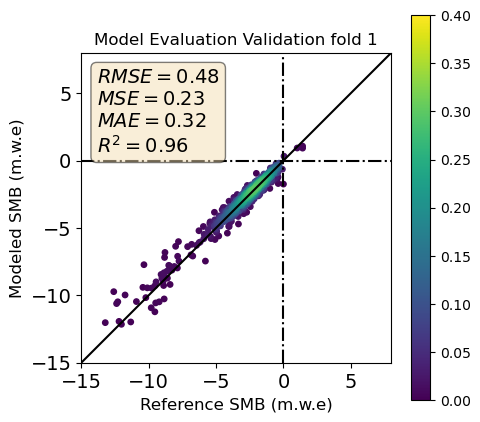

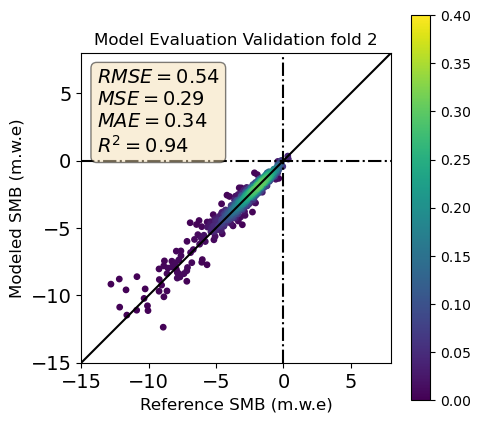

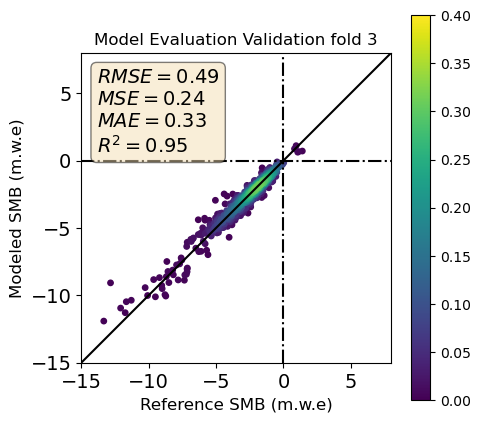

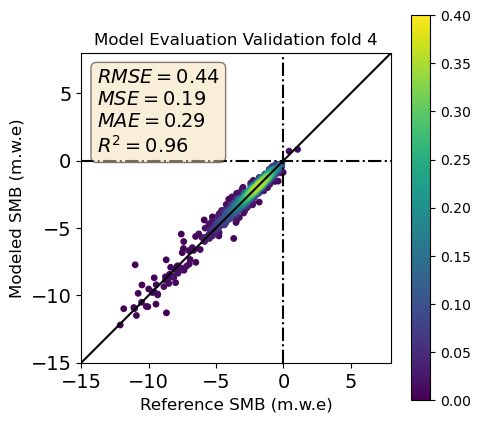

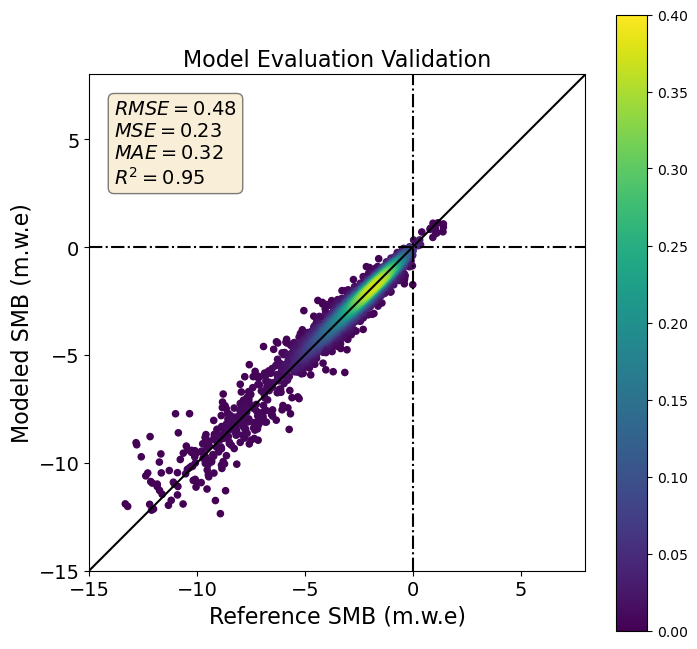

['Models/Final_training/cv_rand_5fold_all_climate_summer.pkl']

In [41]:
# Select features for training
df_train_X = df_train_summer_clean.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y = df_train_summer_clean[['balance']]

# Get arrays of features and targets
X_train, y_train = df_train_X.values, df_train_y.values

# Set random seed for split
rand_seed = 25

# Use five folds
kf = KFold(n_splits=5, shuffle=True, random_state=rand_seed)
splits = list(kf.split(X_train, y_train))

# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 200, 300, 400, 500], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]}

# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train, y_train, splits, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

# Save cv-object
joblib.dump(cv_grid, 'Models/Final_training/cv_rand_5fold_all_climate_summer.pkl')

### 2.4 Winter mass balance

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Cross validation score:  -0.15241587356683997
Grid search best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}
Cross validation scores per fold:  [-0.15268747 -0.15752383 -0.16049152 -0.1491719  -0.14220464]
Mean cross validation score:  -0.15241587356683997
Standard deviation:  0.006421427650500052


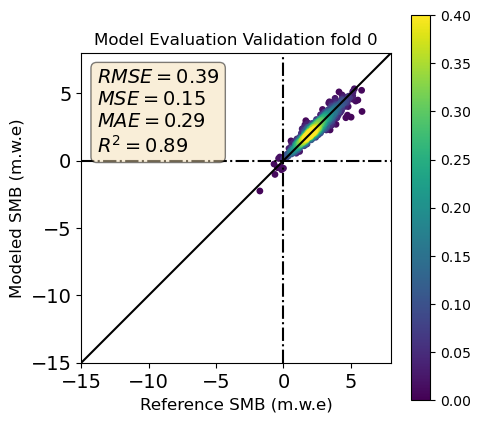

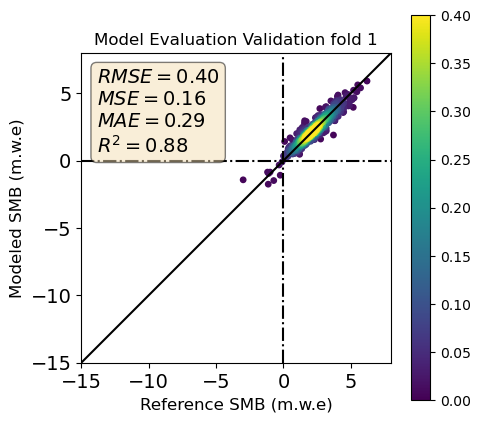

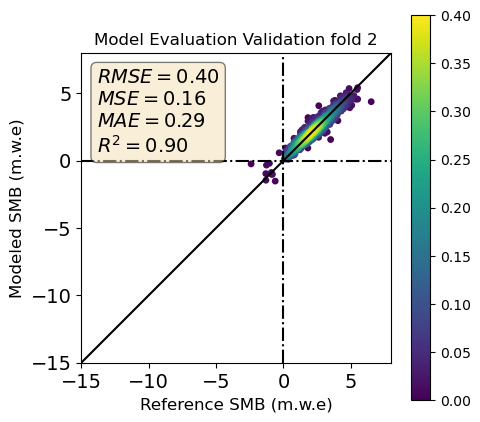

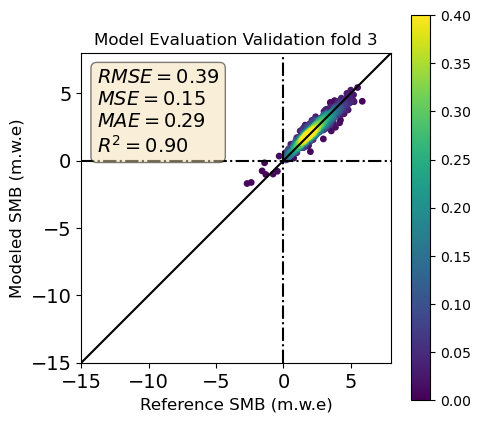

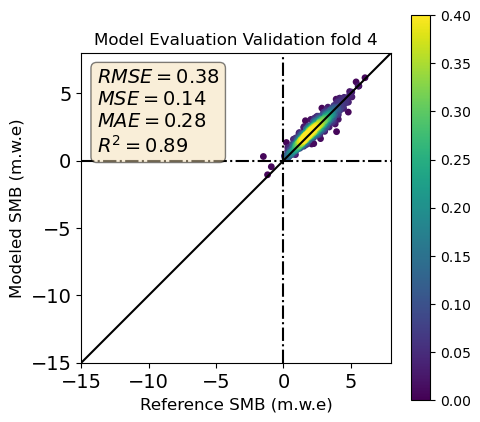

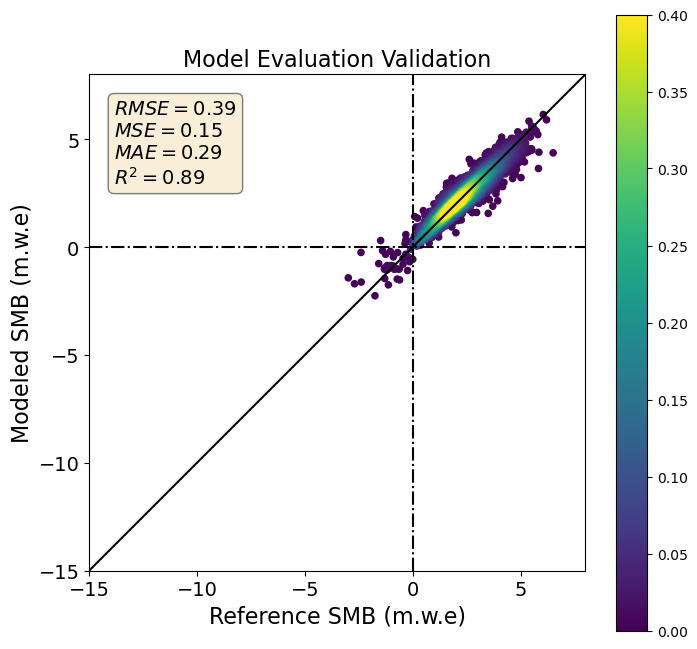

['Models/Final_training/cv_rand_5fold_all_climate_winter.pkl']

In [42]:
# Select features for training
df_train_X = df_train_winter_clean.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y = df_train_winter_clean[['balance']]

# Get arrays of features and targets
X_train, y_train = df_train_X.values, df_train_y.values

# Set random seed for split
rand_seed = 25

# Use five folds
kf = KFold(n_splits=5, shuffle=True, random_state=rand_seed)
splits = list(kf.split(X_train, y_train))

# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 200, 300, 400, 500], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]}

# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train, y_train, splits, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

# Save cv-object
joblib.dump(cv_grid, 'Models/Final_training/cv_rand_5fold_all_climate_winter.pkl')

## 3.0 Model 3: Temperature and precipitation with 5-fold blocking-by-glacier CV
Features: Temperature and precipitation <br>
CV-strategy: 5-fold blocking-by-glacier cross validation <br>
Targets: <br>
3.1: Annual and seasonal observations <br>
3.2: Only annual mass balance <br>
3.3: Only summer mass balance <br>
3.4: Only winter mass balance <br>

### Prepare data

In [70]:
# Select features
base_cols = ['BREID','altitude','aspect','slope','altitude_climate','n_months']
temp_cols = ['t2m_oct','t2m_nov','t2m_dec','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
prec_cols = ['tp_oct','tp_nov','tp_dec','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']
label_cols = ['balance_netto']

# Select features for training
df_train_annual_clean = select_variables(df_train_annual, base_cols, temp_cols, prec_cols, ['balance_netto'])
df_train_winter_clean = select_variables(df_train_winter, base_cols, temp_cols, prec_cols, ['balance_winter'])
df_train_summer_clean = select_variables(df_train_summer, base_cols, temp_cols, prec_cols, ['balance_summer'])

# Rename target columns to same name
df_train_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_train_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_train_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)
var = ['t2m', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep', 'oct']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may']

for name in var:
    for mon in mon_summer:
        df_train_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        df_train_summer_clean[name+'_'+mon]= np.nan

# Combine all annual, winter and summer data in one dataframe
df_train_all = pd.concat([df_train_annual_clean, df_train_summer_clean, df_train_winter_clean])

C:\Users\kasj\AppData\Local\Temp\ipykernel_16048\3002504140.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
C:\Users\kasj\AppData\Local\Temp\ipykernel_16048\3002504140.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
C:\Users\kasj\AppData\Local\Temp\ipykernel_16048\3002504140.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

### 3.1 Annual and seasonal mass balance

In [73]:
df_train_all.columns

Index(['BREID', 'altitude', 'aspect', 'slope', 'altitude_climate', 'n_months',
       't2m_oct', 't2m_nov', 't2m_dec', 't2m_jan', 't2m_feb', 't2m_mar',
       't2m_apr', 't2m_may', 't2m_jun', 't2m_jul', 't2m_aug', 't2m_sep',
       'tp_oct', 'tp_nov', 'tp_dec', 'tp_jan', 'tp_feb', 'tp_mar', 'tp_apr',
       'tp_may', 'tp_jun', 'tp_jul', 'tp_aug', 'tp_sep', 'balance'],
      dtype='object')

In [74]:
# Group together outlet glaciers of Folgefonna by renaming BREID to dummy ID 3000
#df_train_all.loc[df_train_all['BREID'].isin([3126, 3127, 3128, 3129])]=3000

# Shuffle df_train, get X and y values
df_train_s = df_train_all.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

# Select features for training
df_train_X_s = df_train_s.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y_s = df_train_s[['balance']]

# Get values
X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

print('Train, fold 0: ', np.unique(gp_s[splits_s[0][0]]))
print('Validation, fold 0: ', np.unique(gp_s[splits_s[0][1]]))
print('Train, fold 1: ', np.unique(gp_s[splits_s[1][0]]))
print('Validation, fold 1: ', np.unique(gp_s[splits_s[1][1]]))
print('Train, fold 2: ', np.unique(gp_s[splits_s[2][0]]))
print('Validation, fold 2: ', np.unique(gp_s[splits_s[2][1]]))
print('Train, fold 3: ', np.unique(gp_s[splits_s[3][0]]))
print('Validation, fold 3: ', np.unique(gp_s[splits_s[3][1]]))
print('Train, fold 4: ', np.unique(gp_s[splits_s[4][0]]))
print('Validation, fold 4: ', np.unique(gp_s[splits_s[4][1]]))

Train, fold 0:  [ 596  675 1092 1094 1144 2078 2148 2474 2514 2597 2743 2772 2968 3126
 3127 3128 3129]
Validation, fold 0:  [2297]
Train, fold 1:  [ 596  675 1092 1094 1144 2148 2297 2474 2514 2597 2743 2772 2968 3126
 3127 3128 3129]
Validation, fold 1:  [2078]
Train, fold 2:  [ 596  675 1144 2078 2148 2297 2597 2743 2772 2968 3126 3127 3128]
Validation, fold 2:  [1092 1094 2474 2514 3129]
Train, fold 3:  [ 596 1092 1094 2078 2148 2297 2474 2514 2968 3126 3127 3129]
Validation, fold 3:  [ 675 1144 2597 2743 2772 3128]
Train, fold 4:  [ 675 1092 1094 1144 2078 2297 2474 2514 2597 2743 2772 3128 3129]
Validation, fold 4:  [ 596 2148 2968 3126 3127]


In [75]:
df_train_s.shape

(8498, 31)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Cross validation score:  -1.3412720789791108
Grid search best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
Cross validation scores per fold:  [-1.67767321 -1.4364298  -1.23367121 -1.12435715 -1.23422902]
Mean cross validation score:  -1.3412720789791108
Standard deviation:  0.19611678339829874


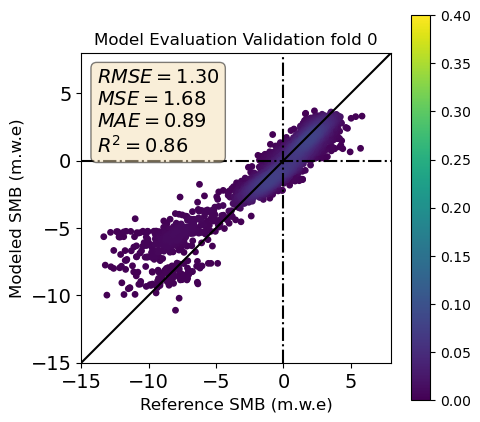

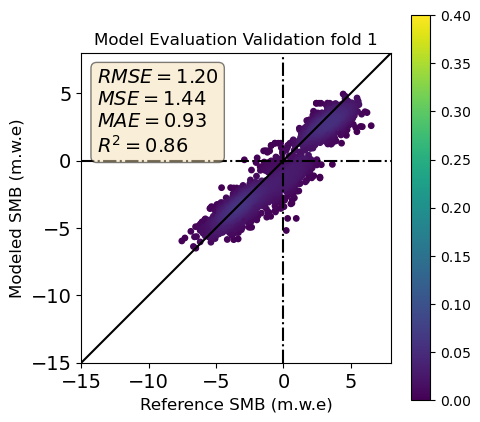

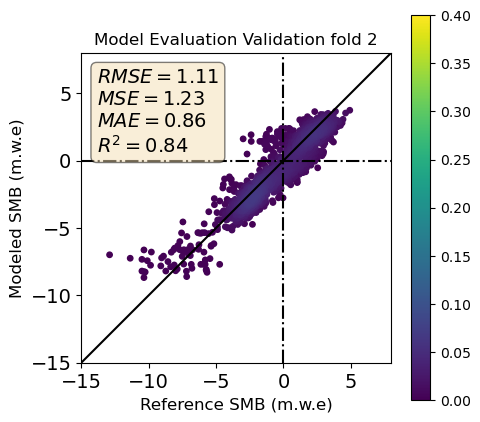

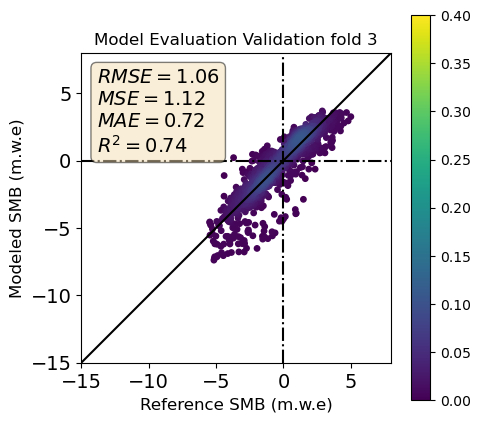

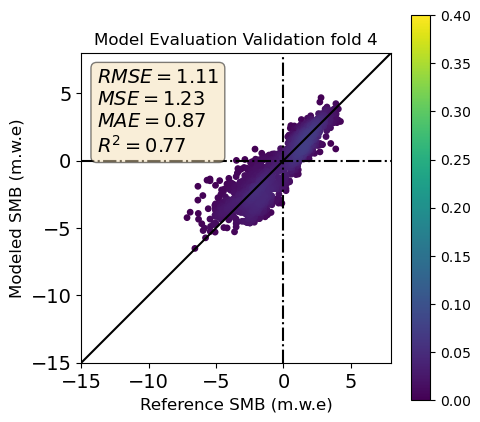

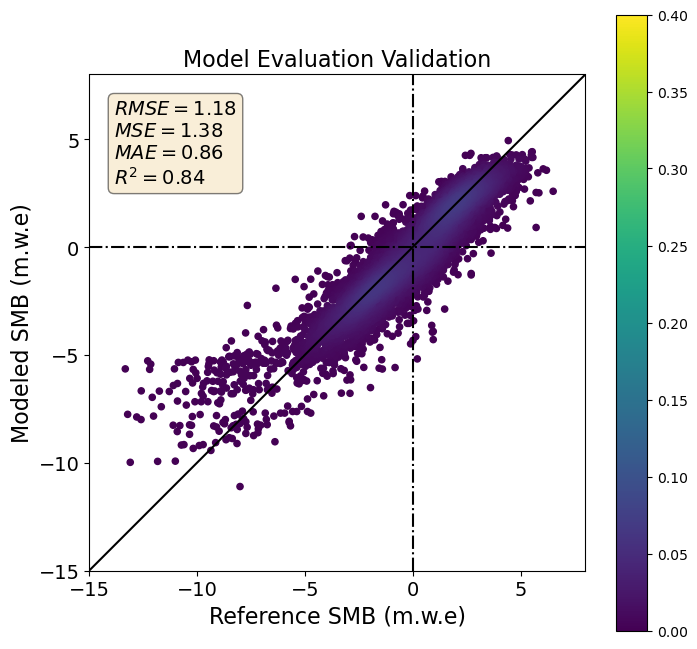

['Models/Final_training/cv_block_glacier_temp_prec_ann+seas_w_nmonths.pkl']

In [76]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 200, 300, 400, 500], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]}

# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

# Save cv-object
joblib.dump(cv_grid, 'Models/Final_training/cv_block_glacier_temp_prec_ann+seas_w_nmonths.pkl')

### 3.2 Annual mass balance

In [79]:
df_train_ann_s = df_train_s[df_train_s['n_months']==12]


In [84]:
df_train_ann_s.shape

(2845, 31)

In [101]:
sorter = list(df_train_s.BREID.unique())
sorter

[3128,
 2297,
 1094,
 2078,
 596,
 1144,
 675,
 3129,
 3127,
 1092,
 2968,
 3126,
 2474,
 2148,
 2772,
 2514,
 2597,
 2743]

In [98]:
df = df_train_ann_s.iloc[df_train_ann_s['BREID'].map({v: k for k, v in enumerate(sorter)}).argsort()]


In [108]:
df_train_s

BREID  altitude    aspect     slope  altitude_climate  n_months  \
0      3128    1312.0  0.154869  0.111060        958.993627         6   
1      2297    1618.0  0.159165  0.088595       1382.210502         6   
2      1094    1234.0  6.095931  0.051342        808.263013        12   
3      2078    1141.0  0.241085  0.264984        634.596017         6   
4      2297    1647.0  2.117864  0.093408       1382.210502        12   
...     ...       ...       ...       ...               ...       ...   
8493   2297    1685.0  1.781077  0.052969       1382.210502         8   
8494    675    1396.0  2.459722  0.159199       1025.245691         6   
8495   2078    1043.0  0.059859  0.209804        634.596017         6   
8496   2474    1550.0  5.788721  0.111695       1346.780081        12   
8497    596    1085.0  0.752370  0.261401       1001.181943         6   

         t2m_oct     t2m_nov     t2m_dec     t2m_jan  ...    tp_jan    tp_feb  \
0            NaN         NaN         NaN         NaN  ...       NaN       NaN   
1            NaN         NaN         NaN         NaN  ...       NaN       NaN   
2     270.586090  269.023773  261.826385  261.457428  ...  0.005788  0.002753   
3            NaN         NaN         NaN         NaN  ...       NaN       NaN   
4     268.541718  262.040466  262.056396  263.277100  ...  0.005657  0.002251   
...          ...         ...         ...         ...  ...       ...       ...   
8493         NaN  267.344574  262.309204  257.332275  ...  0.003521  0.005744   
8494         NaN         NaN         NaN         NaN  ...       NaN       NaN   
8495         NaN         NaN         NaN         NaN  ...       NaN       NaN   
8496  272.036041  261.854462  259.306030  259.432831  ...  0.001375  0.001639   
8497         NaN         NaN         NaN         NaN  ...       NaN       NaN   

        tp_mar    tp_apr    tp_may    tp_jun    tp_jul    tp_aug    tp_sep  \
0          NaN       NaN       NaN  0.006694  0.002443  0.006485  0.007533   
1          NaN       NaN       NaN  0.002446  0.005685  0.007217  0.007370   
2     0.005574  0.005044  0.003403  0.006130  0.006770  0.003661  0.001990   
3          NaN       NaN       NaN  0.005415  0.005205  0.003574  0.004732   
4     0.003153  0.003520  0.001913  0.002004  0.007230  0.002486  0.009946   
...        ...       ...       ...       ...       ...       ...       ...   
8493  0.002009  0.003706       NaN       NaN       NaN       NaN       NaN   
8494       NaN       NaN       NaN  0.002436  0.003612  0.002770  0.002834   
8495       NaN       NaN       NaN  0.006845  0.008522  0.006509  0.003235   
8496  0.003028  0.001913  0.002439  0.002757  0.007281  0.003330  0.005289   
8497       NaN       NaN       NaN  0.004824  0.003683  0.004470  0.001097   

      balance  
0       -3.39  
1       -2.40  
2        0.21  
3       -2.91  
4       -0.50  
...       ...  
8493     2.53  
8494    -1.20  
8495    -4.15  
8496    -0.16  
8497    -1.13  

[8498 rows x 31 columns]

In [106]:
# Group together outlet glaciers of Folgefonna by renaming BREID to dummy ID 3000
#df_train_annual_clean.loc[df_train_annual_clean['BREID'].isin([3126, 3127, 3128, 3129])]=3000

# Get annual data
df_train_ann_s = df_train_s[df_train_s['n_months']==12]

# Get order of glacier ID in shuffled dataframe
sorter = list(df_train_s.BREID.unique())

# Sort dataframe of annual mb according to list
# This is to get same folds as when using all data
df_train_ann_s = df_train_ann_s.iloc[df_train_ann_s['BREID'].map({v: k for k, v in enumerate(sorter)}).argsort()]
df_train_ann_s.reset_index(inplace=True, drop=True)

# Select features for training
df_train_X_s = df_train_ann_s.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y_s = df_train_ann_s[['balance']]

# Get values
X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_ann_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

print('Train, fold 0: ', np.unique(gp_s[splits_s[0][0]]))
print('Validation, fold 0: ', np.unique(gp_s[splits_s[0][1]]))
print('Train, fold 1: ', np.unique(gp_s[splits_s[1][0]]))
print('Validation, fold 1: ', np.unique(gp_s[splits_s[1][1]]))
print('Train, fold 2: ', np.unique(gp_s[splits_s[2][0]]))
print('Validation, fold 2: ', np.unique(gp_s[splits_s[2][1]]))
print('Train, fold 3: ', np.unique(gp_s[splits_s[3][0]]))
print('Validation, fold 3: ', np.unique(gp_s[splits_s[3][1]]))
print('Train, fold 4: ', np.unique(gp_s[splits_s[4][0]]))
print('Validation, fold 4: ', np.unique(gp_s[splits_s[4][1]]))

Train, fold 0:  [ 596  675 1092 1094 1144 2078 2148 2474 2514 2597 2743 2772 2968 3126
 3127 3128 3129]
Validation, fold 0:  [2297]
Train, fold 1:  [ 596  675 1092 1094 1144 2148 2297 2474 2514 2597 2743 2772 2968 3126
 3127 3128 3129]
Validation, fold 1:  [2078]
Train, fold 2:  [ 596  675 1092 1144 2078 2148 2297 2772 2968 3126 3127 3128]
Validation, fold 2:  [1094 2474 2514 2597 2743 3129]
Train, fold 3:  [ 596 1094 2078 2148 2297 2474 2514 2597 2743 2968 3126 3127 3129]
Validation, fold 3:  [ 675 1092 1144 2772 3128]
Train, fold 4:  [ 675 1092 1094 1144 2078 2297 2474 2514 2597 2743 2772 3128 3129]
Validation, fold 4:  [ 596 2148 2968 3126 3127]


Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Cross validation score:  -1.8047953054310697
Grid search best hyperparameters:  {'learning_rate': 0.25, 'max_depth': 2, 'n_estimators': 500}
Cross validation scores per fold:  [-1.49219119 -2.14632323 -1.65779081 -1.7131183  -2.01455299]
Mean cross validation score:  -1.8047953054310697
Standard deviation:  0.24015658896628178


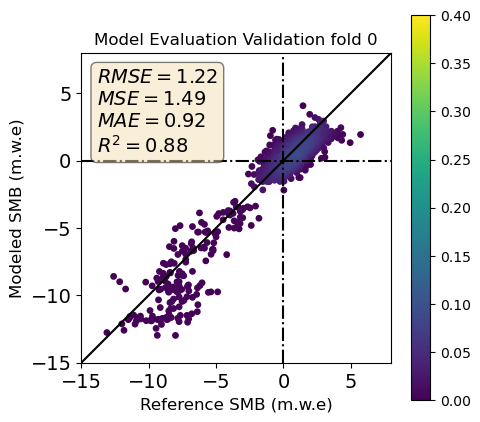

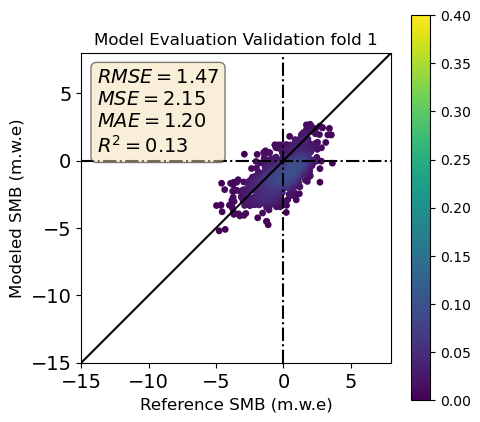

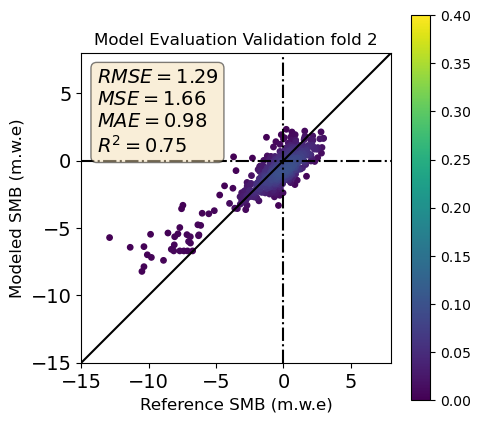

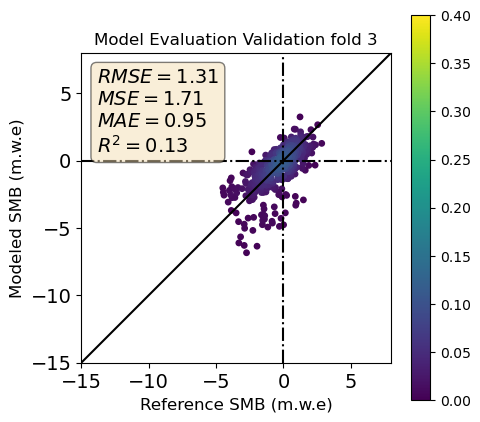

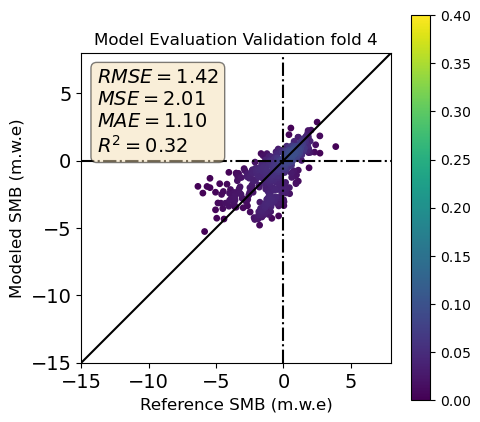

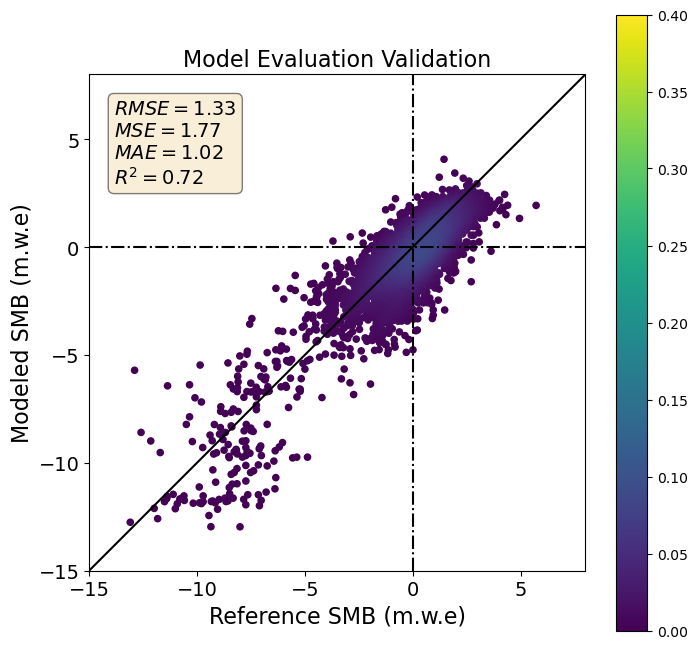

['Models/Final_training/cv_block_glacier_temp_prec_annual.pkl']

In [109]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 200, 300, 400, 500], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]}

# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

# Save cv-object
joblib.dump(cv_grid, 'Models/Final_training/cv_block_glacier_temp_prec_annual.pkl')

### 3.3 Summer mass balance

In [111]:
# Group together outlet glaciers of Folgefonna by renaming BREID to dummy ID 3000
#df_train_summer_clean.loc[df_train_summer_clean['BREID'].isin([3126, 3127, 3128, 3129])]=3000

# Get summer data
df_train_summer_s = df_train_s[df_train_s['n_months']==6]

# Get order of glacier ID in shuffled dataframe
sorter = list(df_train_s.BREID.unique())

# Sort dataframe of annual mb according to list
# This is to get same folds as when using all data
df_train_summer_s = df_train_summer_s.iloc[df_train_summer_s['BREID'].map({v: k for k, v in enumerate(sorter)}).argsort()]
df_train_summer_s.reset_index(inplace=True, drop=True)

# Shuffle df_train, get X and y values
#df_train_s = df_train_summer_clean.sample(frac=1, random_state=5)
#df_train_s.reset_index(drop=True, inplace=True)

# Select features for training
df_train_X_s = df_train_summer_s.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y_s = df_train_summer_s[['balance']]

# Get values
X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_summer_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

print('Train, fold 0: ', np.unique(gp_s[splits_s[0][0]]))
print('Validation, fold 0: ', np.unique(gp_s[splits_s[0][1]]))
print('Train, fold 1: ', np.unique(gp_s[splits_s[1][0]]))
print('Validation, fold 1: ', np.unique(gp_s[splits_s[1][1]]))
print('Train, fold 2: ', np.unique(gp_s[splits_s[2][0]]))
print('Validation, fold 2: ', np.unique(gp_s[splits_s[2][1]]))
print('Train, fold 3: ', np.unique(gp_s[splits_s[3][0]]))
print('Validation, fold 3: ', np.unique(gp_s[splits_s[3][1]]))
print('Train, fold 4: ', np.unique(gp_s[splits_s[4][0]]))
print('Validation, fold 4: ', np.unique(gp_s[splits_s[4][1]]))

Train, fold 0:  [ 596  675 1092 1094 1144 2078 2148 2474 2514 2597 2743 2772 2968 3126
 3127 3128 3129]
Validation, fold 0:  [2297]
Train, fold 1:  [ 596  675 1092 1094 1144 2148 2297 2474 2514 2597 2743 2772 2968 3126
 3127 3128 3129]
Validation, fold 1:  [2078]
Train, fold 2:  [ 596  675 1144 2078 2148 2297 2514 2597 2743 2968 3127 3128 3129]
Validation, fold 2:  [1092 1094 2474 2772 3126]
Train, fold 3:  [ 596 1092 1094 2078 2148 2297 2474 2514 2597 2772 2968 3126 3127]
Validation, fold 3:  [ 675 1144 2743 3128 3129]
Train, fold 4:  [ 675 1092 1094 1144 2078 2297 2474 2743 2772 3126 3128 3129]
Validation, fold 4:  [ 596 2148 2514 2597 2968 3127]


Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Cross validation score:  -1.0218708787796547
Grid search best hyperparameters:  {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 500}
Cross validation scores per fold:  [-1.91894969 -0.98762794 -0.98613556 -0.5061521  -0.71048911]
Mean cross validation score:  -1.0218708787796547
Standard deviation:  0.48376119009640073


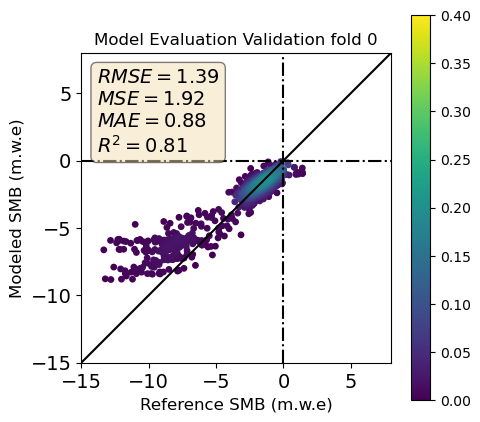

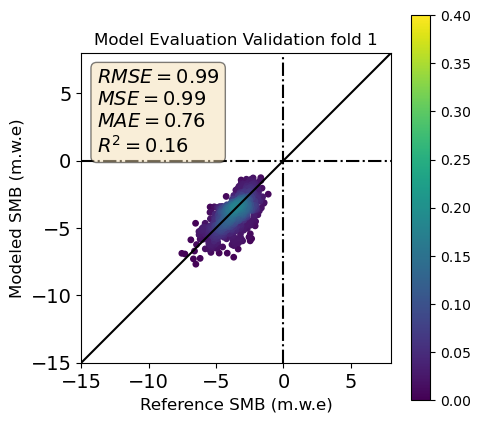

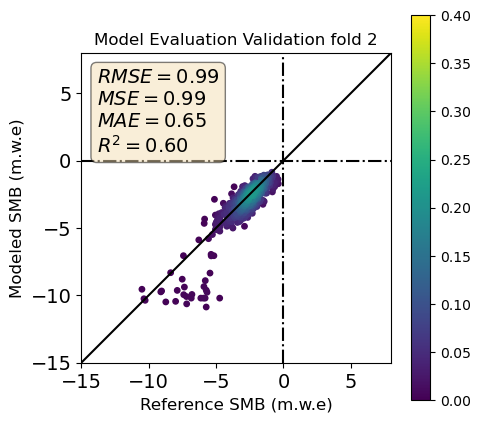

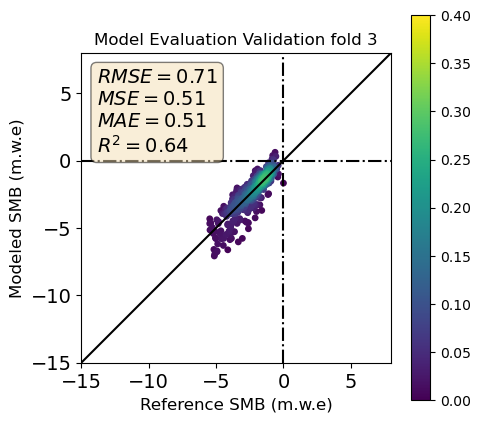

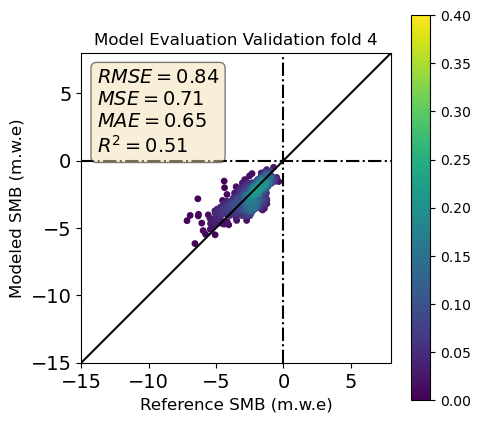

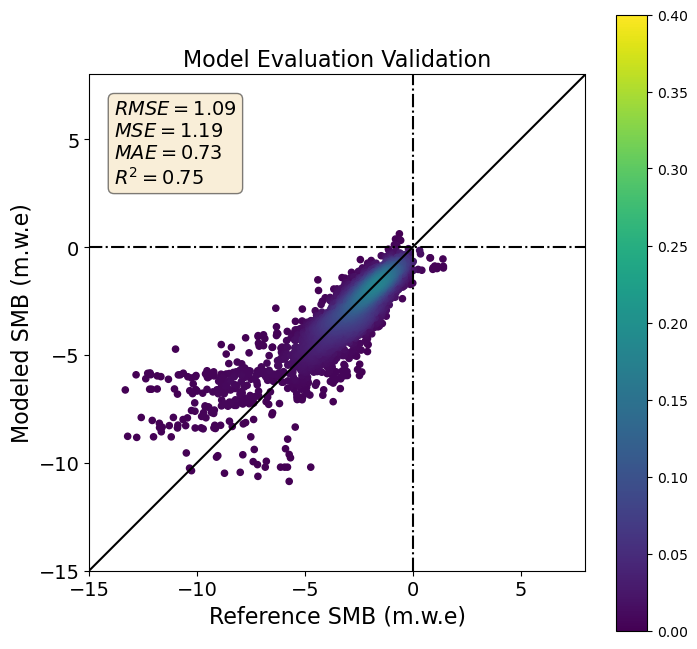

['Models/Final_training/cv_block_glacier_temp_prec_summer.pkl']

In [112]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 200, 300, 400, 500], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]}

# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

# Save cv-object
joblib.dump(cv_grid, 'Models/Final_training/cv_block_glacier_temp_prec_summer.pkl')

### 3.4 Winter mass balance

In [114]:
# Group together outlet glaciers of Folgefonna by renaming BREID to dummy ID 3000
#df_train_summer_clean.loc[df_train_summer_clean['BREID'].isin([3126, 3127, 3128, 3129])]=3000

# Get summer data
df_train_winter_s = df_train_s[df_train_s['n_months']==8]

# Get order of glacier ID in shuffled dataframe
sorter = list(df_train_s.BREID.unique())

# Sort dataframe of annual mb according to list
# This is to get same folds as when using all data
df_train_winter_s = df_train_winter_s.iloc[df_train_winter_s['BREID'].map({v: k for k, v in enumerate(sorter)}).argsort()]
df_train_winter_s.reset_index(inplace=True, drop=True)

# Shuffle df_train, get X and y values
#df_train_s = df_train_summer_clean.sample(frac=1, random_state=5)
#df_train_s.reset_index(drop=True, inplace=True)

# Select features for training
df_train_X_s = df_train_winter_s.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y_s = df_train_winter_s[['balance']]

# Get values
X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_winter_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

print('Train, fold 0: ', np.unique(gp_s[splits_s[0][0]]))
print('Validation, fold 0: ', np.unique(gp_s[splits_s[0][1]]))
print('Train, fold 1: ', np.unique(gp_s[splits_s[1][0]]))
print('Validation, fold 1: ', np.unique(gp_s[splits_s[1][1]]))
print('Train, fold 2: ', np.unique(gp_s[splits_s[2][0]]))
print('Validation, fold 2: ', np.unique(gp_s[splits_s[2][1]]))
print('Train, fold 3: ', np.unique(gp_s[splits_s[3][0]]))
print('Validation, fold 3: ', np.unique(gp_s[splits_s[3][1]]))
print('Train, fold 4: ', np.unique(gp_s[splits_s[4][0]]))
print('Validation, fold 4: ', np.unique(gp_s[splits_s[4][1]]))

Train, fold 0:  [ 596  675 1092 1094 1144 2078 2148 2474 2514 2597 2743 2772 2968 3126
 3127 3128 3129]
Validation, fold 0:  [2297]
Train, fold 1:  [ 596  675 1092 1094 1144 2148 2297 2474 2514 2597 2743 2772 2968 3126
 3127 3128 3129]
Validation, fold 1:  [2078]
Train, fold 2:  [ 596  675 1092 1144 2078 2148 2297 2597 2772 2968 3126 3127 3128]
Validation, fold 2:  [1094 2474 2514 2743 3129]
Train, fold 3:  [ 596 1092 1094 2078 2297 2474 2514 2597 2743 2968 3126 3127 3129]
Validation, fold 3:  [ 675 1144 2148 2772 3128]
Train, fold 4:  [ 675 1094 1144 2078 2148 2297 2474 2514 2743 2772 3128 3129]
Validation, fold 4:  [ 596 1092 2597 2968 3126 3127]


Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Cross validation score:  -0.7409380543009508
Grid search best hyperparameters:  {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 500}
Cross validation scores per fold:  [-0.52812734 -1.04040173 -1.38633731 -0.3673955  -0.38242839]
Mean cross validation score:  -0.7409380543009508
Standard deviation:  0.40486301669766106


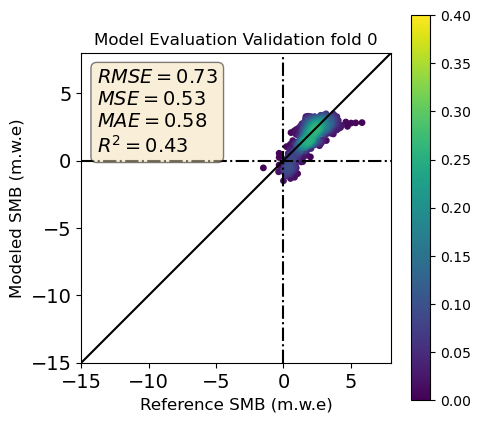

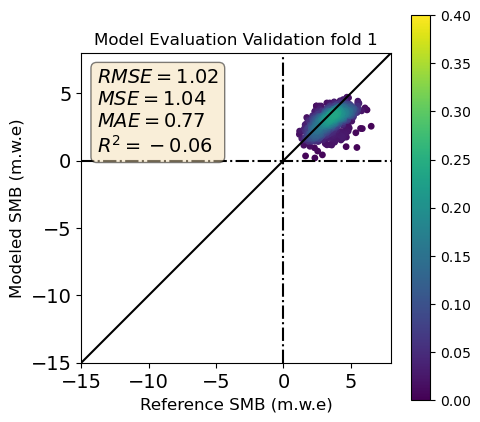

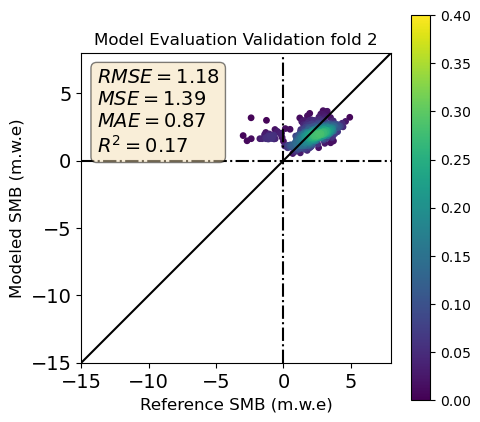

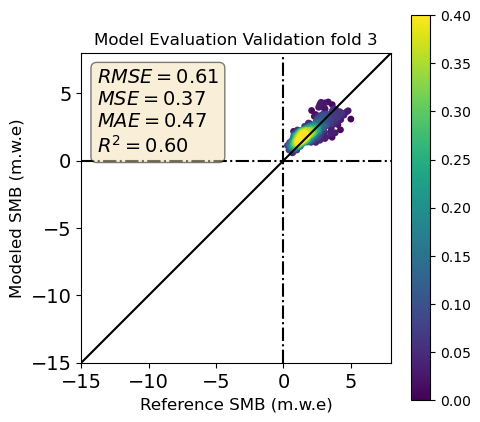

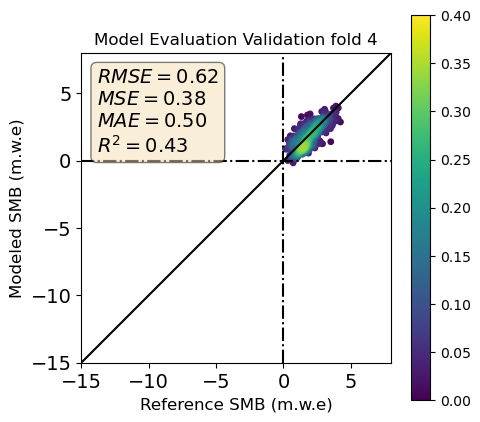

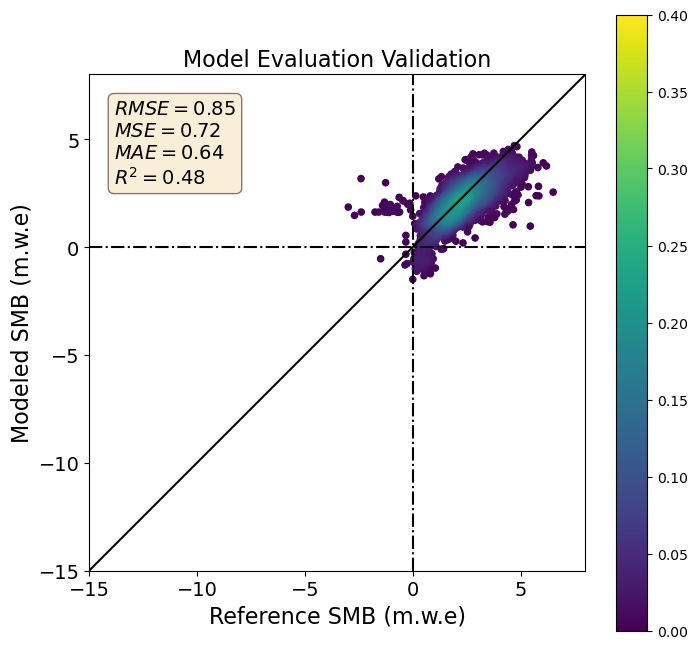

['Models/Final_training/cv_block_glacier_temp_prec_winter.pkl']

In [115]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 200, 300, 400, 500], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]}

# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

# Save cv-object
joblib.dump(cv_grid, 'Models/Final_training/cv_block_glacier_temp_prec_winter.pkl')

## 4.0 Model 4: Energy balance variables with 5-fold blocking-by-glacier CV
Features: ERA5-Land meteorological variables <br>
CV-strategy: 5-fold blocking-by-glacier cross validation <br>
Targets: <br>
4.1: Annual and seasonal observations <br>
4.2: Only annual mass balance <br>
4.3: Only summer mass balance <br>
4.4: Only winter mass balance <br>

### Prepare data

In [128]:
# Select columns to drop
cols = ['RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border','year', 'lat','lon', 'slope_factor']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']
dewpt_temp = ['d2m_oct','d2m_nov','d2m_dec','d2m_jan','d2m_feb','d2m_mar','d2m_apr','d2m_may','d2m_jun','d2m_jul','d2m_aug','d2m_sep']
surface_pressure = ['sp_oct','sp_nov','sp_dec','sp_jan','sp_feb','sp_mar','sp_apr','sp_may','sp_jun','sp_jul','sp_aug','sp_sep']
sol_rad_net = ['ssr_oct','ssr_nov','ssr_dec','ssr_jan','ssr_feb','ssr_mar','ssr_apr','ssr_may','ssr_jun','ssr_jul','ssr_aug','ssr_sep']
sol_therm_down = ['strd_oct','strd_nov','strd_dec','strd_jan','strd_feb','strd_mar','strd_apr','strd_may','strd_jun','strd_jul','strd_aug','strd_sep']
#sol_rad_down = ['ssrd_oct','ssrd_nov','ssrd_dec','ssrd_jan','ssrd_feb','ssrd_mar','ssrd_apr','ssrd_may','ssrd_jun','ssrd_jul','ssrd_aug','ssrd_sep']
u_wind = ['u10_oct','u10_nov','u10_dec','u10_jan','u10_feb','u10_mar','u10_apr','u10_may','u10_jun','u10_jul','u10_aug','u10_sep']
v_wind = ['v10_oct','v10_nov','v10_dec','v10_jan','v10_feb','v10_mar','v10_apr','v10_may','v10_jun','v10_jul','v10_aug','v10_sep']
#f_albedo = ['fal_oct','fal_nov','fal_dec','fal_jan','fal_feb','fal_mar','fal_apr','fal_may','fal_jun','fal_jul','fal_aug','fal_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo, 
                         dewpt_temp, surface_pressure, sol_rad_net, sol_therm_down, u_wind, v_wind] for y in x]

# Select features for training
df_train_annual_clean = df_train_annual.drop(drop_cols, axis=1)
df_train_winter_clean = df_train_winter.drop(drop_cols, axis=1)
df_train_summer_clean = df_train_summer.drop(drop_cols, axis=1)
df_train_annual_clean = df_train_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_train_winter_clean = df_train_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_train_summer_clean = df_train_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_train_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_train_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_train_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# df_train_X_... now contains columns of all chosen features and column with annual, winter or summer balance

# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)
var = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep', 'oct']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may']

for name in var:
    for mon in mon_summer:
        df_train_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        df_train_summer_clean[name+'_'+mon]= np.nan

# Combine all annual, winter and summer data in one dataframe
df_train_all = pd.concat([df_train_annual_clean, df_train_summer_clean, df_train_winter_clean])

### 4.1 Ann + seas

In [129]:
# Group together outlet glaciers of Folgefonna by renaming BREID to dummy ID 3000
#df_train_all.loc[df_train_all['BREID'].isin([3126, 3127, 3128, 3129])]=3000

# Shuffle df_train, get X and y values
df_train_s = df_train_all.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

# Select features for training
df_train_X_s = df_train_s.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y_s = df_train_s[['balance']]

# Get values
X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

print('Train, fold 0: ', np.unique(gp_s[splits_s[0][0]]))
print('Validation, fold 0: ', np.unique(gp_s[splits_s[0][1]]))
print('Train, fold 1: ', np.unique(gp_s[splits_s[1][0]]))
print('Validation, fold 1: ', np.unique(gp_s[splits_s[1][1]]))
print('Train, fold 2: ', np.unique(gp_s[splits_s[2][0]]))
print('Validation, fold 2: ', np.unique(gp_s[splits_s[2][1]]))
print('Train, fold 3: ', np.unique(gp_s[splits_s[3][0]]))
print('Validation, fold 3: ', np.unique(gp_s[splits_s[3][1]]))
print('Train, fold 4: ', np.unique(gp_s[splits_s[4][0]]))
print('Validation, fold 4: ', np.unique(gp_s[splits_s[4][1]]))

Train, fold 0:  [ 596  675 1092 1094 1144 2078 2148 2474 2514 2597 2743 2772 2968 3126
 3127 3128 3129]
Validation, fold 0:  [2297]
Train, fold 1:  [ 596  675 1092 1094 1144 2148 2297 2474 2514 2597 2743 2772 2968 3126
 3127 3128 3129]
Validation, fold 1:  [2078]
Train, fold 2:  [ 596  675 1144 2078 2148 2297 2597 2743 2772 2968 3126 3127 3128]
Validation, fold 2:  [1092 1094 2474 2514 3129]
Train, fold 3:  [ 596 1092 1094 2078 2148 2297 2474 2514 2968 3126 3127 3129]
Validation, fold 3:  [ 675 1144 2597 2743 2772 3128]
Train, fold 4:  [ 675 1092 1094 1144 2078 2297 2474 2514 2597 2743 2772 3128 3129]
Validation, fold 4:  [ 596 2148 2968 3126 3127]


Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Cross validation score:  -1.351097464594178
Grid search best hyperparameters:  {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 500}
Cross validation scores per fold:  [-1.55523143 -1.48773776 -1.42338469 -1.22905868 -1.06007476]
Mean cross validation score:  -1.351097464594178
Standard deviation:  0.1817439784489964


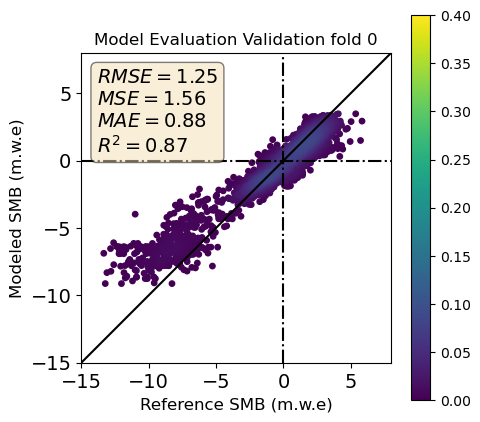

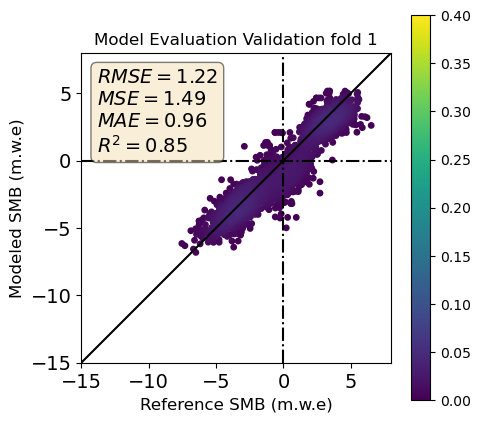

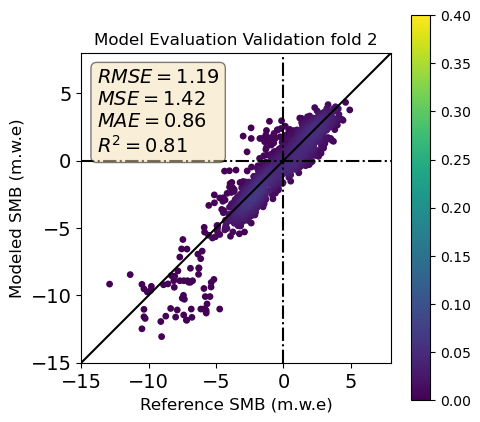

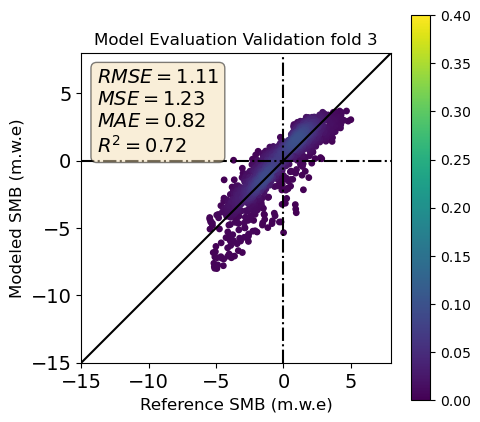

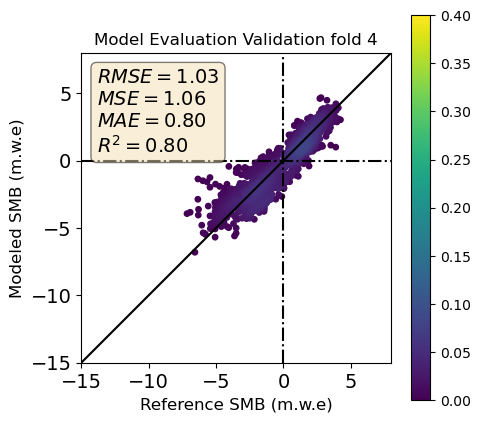

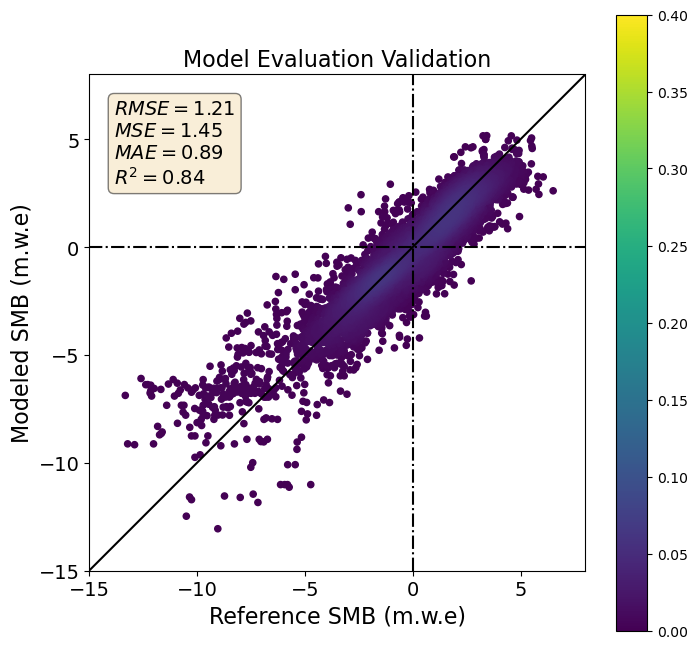

['Models/Final_training/cv_block_glacier_all_climate_ann+seas.pkl']

In [130]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 200, 300, 400, 500], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]}

# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

# Save cv-object
joblib.dump(cv_grid, 'Models/Final_training/cv_block_glacier_all_climate_ann+seas.pkl')

### 4.1 Annual mass balance

In [119]:
# Group together outlet glaciers of Folgefonna by renaming BREID to dummy ID 3000
#df_train_annual_clean.loc[df_train_annual_clean['BREID'].isin([3126, 3127, 3128, 3129])]=3000

# Get annual data
df_train_ann_s = df_train_s[df_train_s['n_months']==12]

# Get order of glacier ID in shuffled dataframe
sorter = list(df_train_s.BREID.unique())

# Sort dataframe of annual mb according to list
# This is to get same folds as when using all data
df_train_ann_s = df_train_ann_s.iloc[df_train_ann_s['BREID'].map({v: k for k, v in enumerate(sorter)}).argsort()]
df_train_ann_s.reset_index(inplace=True, drop=True)

# Select features for training
df_train_X_s = df_train_ann_s.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y_s = df_train_ann_s[['balance']]

# Get values
X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_ann_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

print('Train, fold 0: ', np.unique(gp_s[splits_s[0][0]]))
print('Validation, fold 0: ', np.unique(gp_s[splits_s[0][1]]))
print('Train, fold 1: ', np.unique(gp_s[splits_s[1][0]]))
print('Validation, fold 1: ', np.unique(gp_s[splits_s[1][1]]))
print('Train, fold 2: ', np.unique(gp_s[splits_s[2][0]]))
print('Validation, fold 2: ', np.unique(gp_s[splits_s[2][1]]))
print('Train, fold 3: ', np.unique(gp_s[splits_s[3][0]]))
print('Validation, fold 3: ', np.unique(gp_s[splits_s[3][1]]))
print('Train, fold 4: ', np.unique(gp_s[splits_s[4][0]]))
print('Validation, fold 4: ', np.unique(gp_s[splits_s[4][1]]))

Train, fold 0:  [ 596  675 1092 1094 1144 2078 2148 2474 2514 2597 2743 2772 2968 3126
 3127 3128 3129]
Validation, fold 0:  [2297]
Train, fold 1:  [ 596  675 1092 1094 1144 2148 2297 2474 2514 2597 2743 2772 2968 3126
 3127 3128 3129]
Validation, fold 1:  [2078]
Train, fold 2:  [ 596  675 1092 1144 2078 2148 2297 2772 2968 3126 3127 3128]
Validation, fold 2:  [1094 2474 2514 2597 2743 3129]
Train, fold 3:  [ 596 1094 2078 2148 2297 2474 2514 2597 2743 2968 3126 3127 3129]
Validation, fold 3:  [ 675 1092 1144 2772 3128]
Train, fold 4:  [ 675 1092 1094 1144 2078 2297 2474 2514 2597 2743 2772 3128 3129]
Validation, fold 4:  [ 596 2148 2968 3126 3127]


Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Cross validation score:  -1.919806454421802
Grid search best hyperparameters:  {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300}
Cross validation scores per fold:  [-1.92952268 -2.18490008 -1.45116877 -1.98776596 -2.04567478]
Mean cross validation score:  -1.919806454421802
Standard deviation:  0.24917931287673376


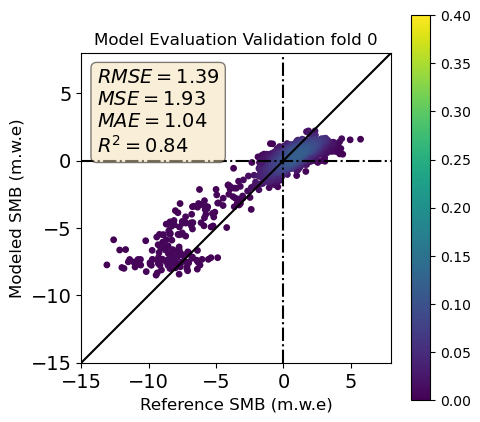

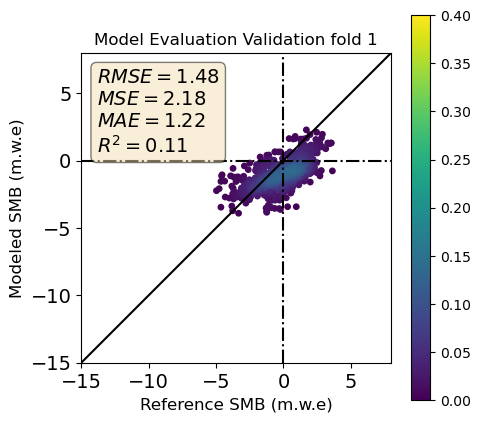

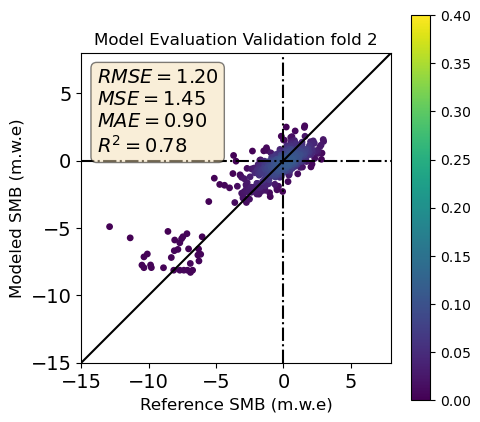

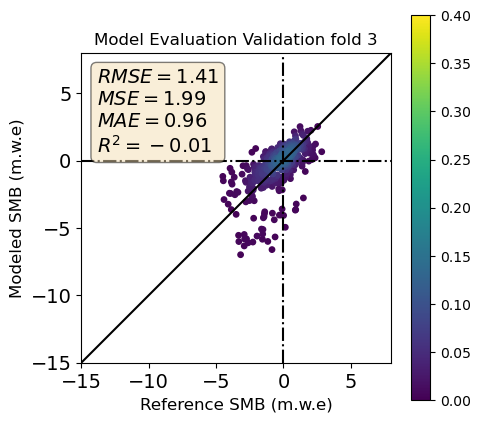

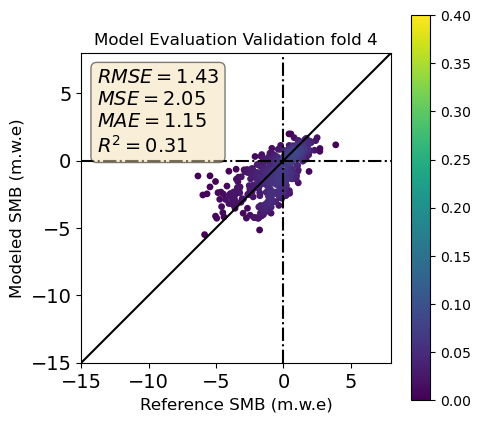

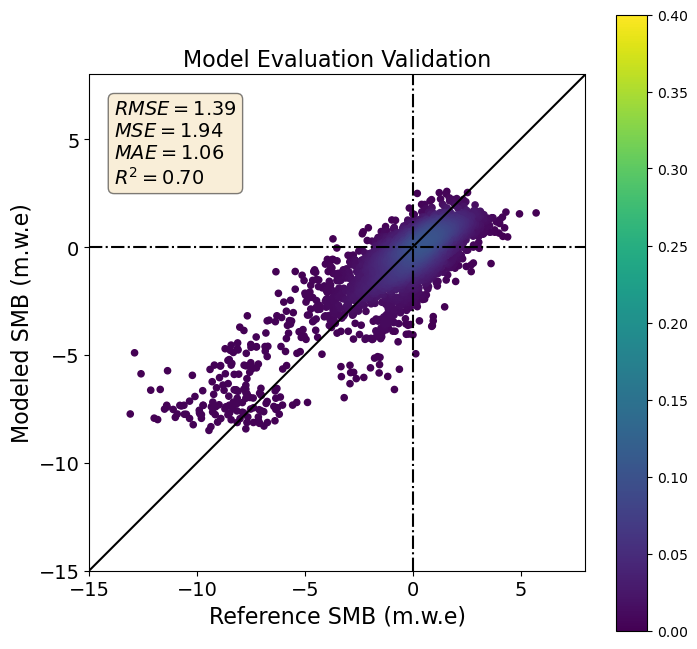

['Models/Final_training/cv_block_glacier_all_climate_ann+seas.pkl']

In [120]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 200, 300, 400, 500], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]}

# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

# Save cv-object
joblib.dump(cv_grid, 'Models/Final_training/cv_block_glacier_all_climate_annual.pkl')

### Summer mass balance

In [122]:
# Group together outlet glaciers of Folgefonna by renaming BREID to dummy ID 3000
#df_train_summer_clean.loc[df_train_summer_clean['BREID'].isin([3126, 3127, 3128, 3129])]=3000

# Get summer data
df_train_summer_s = df_train_s[df_train_s['n_months']==6]

# Get order of glacier ID in shuffled dataframe
sorter = list(df_train_s.BREID.unique())

# Sort dataframe of annual mb according to list
# This is to get same folds as when using all data
df_train_summer_s = df_train_summer_s.iloc[df_train_summer_s['BREID'].map({v: k for k, v in enumerate(sorter)}).argsort()]
df_train_summer_s.reset_index(inplace=True, drop=True)

# Shuffle df_train, get X and y values
#df_train_s = df_train_summer_clean.sample(frac=1, random_state=5)
#df_train_s.reset_index(drop=True, inplace=True)

# Select features for training
df_train_X_s = df_train_summer_s.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y_s = df_train_summer_s[['balance']]

# Get values
X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_summer_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

print('Train, fold 0: ', np.unique(gp_s[splits_s[0][0]]))
print('Validation, fold 0: ', np.unique(gp_s[splits_s[0][1]]))
print('Train, fold 1: ', np.unique(gp_s[splits_s[1][0]]))
print('Validation, fold 1: ', np.unique(gp_s[splits_s[1][1]]))
print('Train, fold 2: ', np.unique(gp_s[splits_s[2][0]]))
print('Validation, fold 2: ', np.unique(gp_s[splits_s[2][1]]))
print('Train, fold 3: ', np.unique(gp_s[splits_s[3][0]]))
print('Validation, fold 3: ', np.unique(gp_s[splits_s[3][1]]))
print('Train, fold 4: ', np.unique(gp_s[splits_s[4][0]]))
print('Validation, fold 4: ', np.unique(gp_s[splits_s[4][1]]))

Train, fold 0:  [ 596  675 1092 1094 1144 2078 2148 2474 2514 2597 2743 2772 2968 3126
 3127 3128 3129]
Validation, fold 0:  [2297]
Train, fold 1:  [ 596  675 1092 1094 1144 2148 2297 2474 2514 2597 2743 2772 2968 3126
 3127 3128 3129]
Validation, fold 1:  [2078]
Train, fold 2:  [ 596  675 1144 2078 2148 2297 2514 2597 2743 2968 3127 3128 3129]
Validation, fold 2:  [1092 1094 2474 2772 3126]
Train, fold 3:  [ 596 1092 1094 2078 2148 2297 2474 2514 2597 2772 2968 3126 3127]
Validation, fold 3:  [ 675 1144 2743 3128 3129]
Train, fold 4:  [ 675 1092 1094 1144 2078 2297 2474 2743 2772 3126 3128 3129]
Validation, fold 4:  [ 596 2148 2514 2597 2968 3127]


Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Cross validation score:  -1.1356611457103027
Grid search best hyperparameters:  {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 200}
Cross validation scores per fold:  [-2.32333407 -0.84661279 -1.0459874  -0.59205855 -0.87031291]
Mean cross validation score:  -1.1356611457103027
Standard deviation:  0.6112398496214901


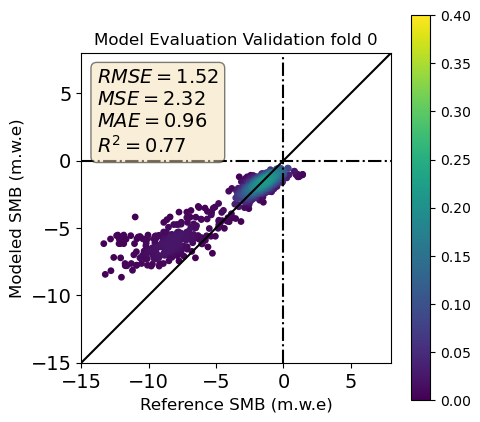

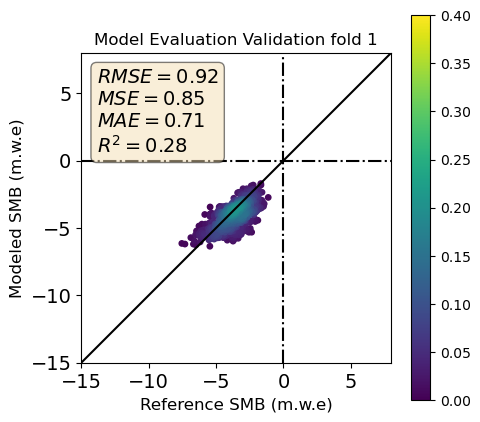

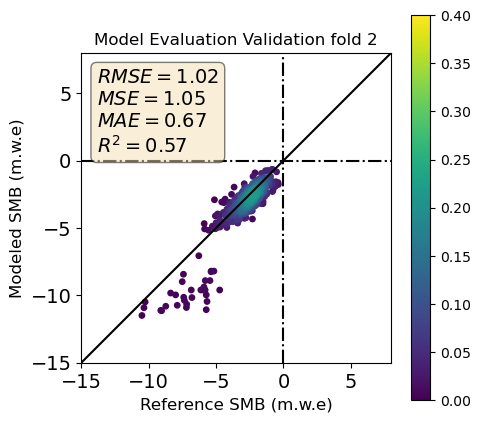

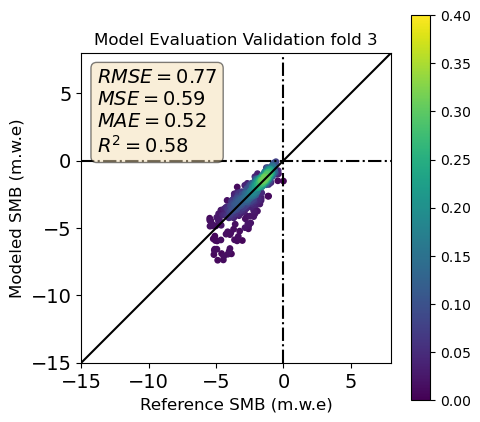

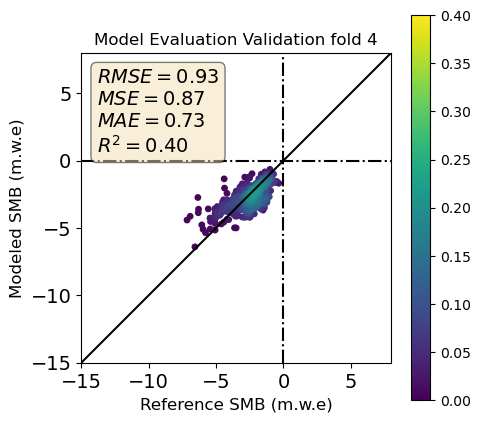

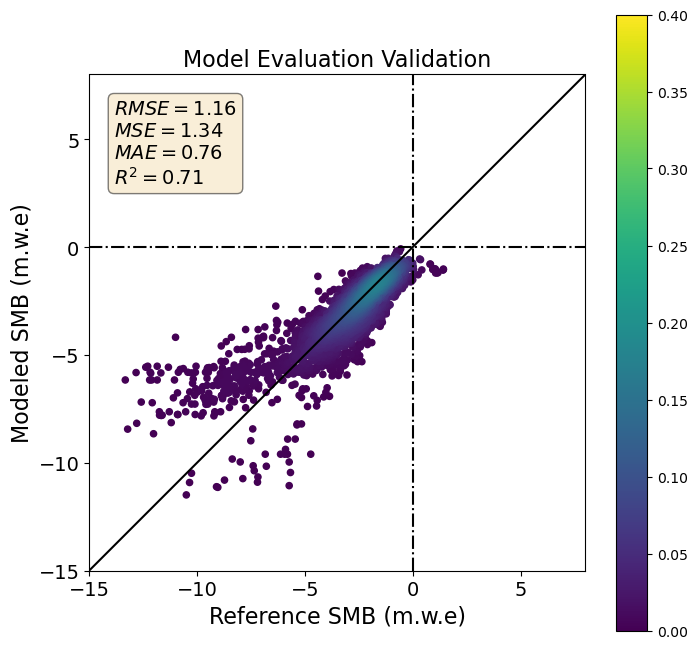

['Models/Final_training/cv_block_glacier_all_climate_summer.pkl']

In [123]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 200, 300, 400, 500], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]}

# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

# Save cv-object
joblib.dump(cv_grid, 'Models/Final_training/cv_block_glacier_all_climate_summer.pkl')

In [124]:
# Group together outlet glaciers of Folgefonna by renaming BREID to dummy ID 3000
#df_train_summer_clean.loc[df_train_summer_clean['BREID'].isin([3126, 3127, 3128, 3129])]=3000

# Get summer data
df_train_winter_s = df_train_s[df_train_s['n_months']==8]

# Get order of glacier ID in shuffled dataframe
sorter = list(df_train_s.BREID.unique())

# Sort dataframe of annual mb according to list
# This is to get same folds as when using all data
df_train_winter_s = df_train_winter_s.iloc[df_train_winter_s['BREID'].map({v: k for k, v in enumerate(sorter)}).argsort()]
df_train_winter_s.reset_index(inplace=True, drop=True)

# Shuffle df_train, get X and y values
#df_train_s = df_train_summer_clean.sample(frac=1, random_state=5)
#df_train_s.reset_index(drop=True, inplace=True)

# Select features for training
df_train_X_s = df_train_winter_s.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y_s = df_train_winter_s[['balance']]

# Get values
X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_winter_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

print('Train, fold 0: ', np.unique(gp_s[splits_s[0][0]]))
print('Validation, fold 0: ', np.unique(gp_s[splits_s[0][1]]))
print('Train, fold 1: ', np.unique(gp_s[splits_s[1][0]]))
print('Validation, fold 1: ', np.unique(gp_s[splits_s[1][1]]))
print('Train, fold 2: ', np.unique(gp_s[splits_s[2][0]]))
print('Validation, fold 2: ', np.unique(gp_s[splits_s[2][1]]))
print('Train, fold 3: ', np.unique(gp_s[splits_s[3][0]]))
print('Validation, fold 3: ', np.unique(gp_s[splits_s[3][1]]))
print('Train, fold 4: ', np.unique(gp_s[splits_s[4][0]]))
print('Validation, fold 4: ', np.unique(gp_s[splits_s[4][1]]))

Train, fold 0:  [ 596  675 1092 1094 1144 2078 2148 2474 2514 2597 2743 2772 2968 3126
 3127 3128 3129]
Validation, fold 0:  [2297]
Train, fold 1:  [ 596  675 1092 1094 1144 2148 2297 2474 2514 2597 2743 2772 2968 3126
 3127 3128 3129]
Validation, fold 1:  [2078]
Train, fold 2:  [ 596  675 1092 1144 2078 2148 2297 2597 2772 2968 3126 3127 3128]
Validation, fold 2:  [1094 2474 2514 2743 3129]
Train, fold 3:  [ 596 1092 1094 2078 2297 2474 2514 2597 2743 2968 3126 3127 3129]
Validation, fold 3:  [ 675 1144 2148 2772 3128]
Train, fold 4:  [ 675 1094 1144 2078 2148 2297 2474 2514 2743 2772 3128 3129]
Validation, fold 4:  [ 596 1092 2597 2968 3126 3127]


Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Cross validation score:  -0.8422888921676464
Grid search best hyperparameters:  {'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 400}
Cross validation scores per fold:  [-0.49277638 -1.25801621 -1.46572831 -0.64594092 -0.34898264]
Mean cross validation score:  -0.8422888921676464
Standard deviation:  0.4394470407481802


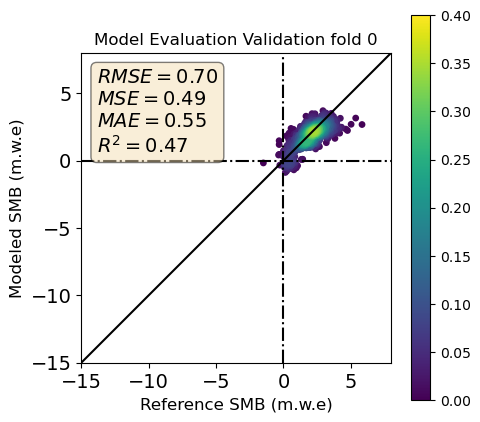

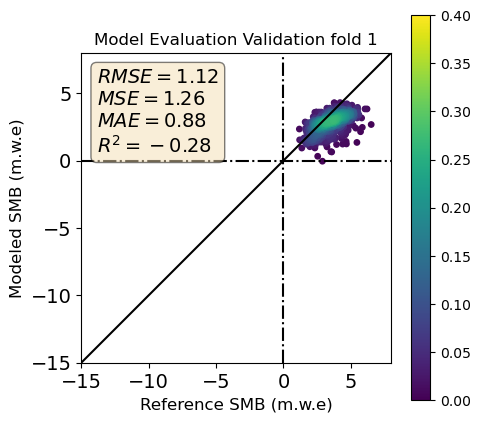

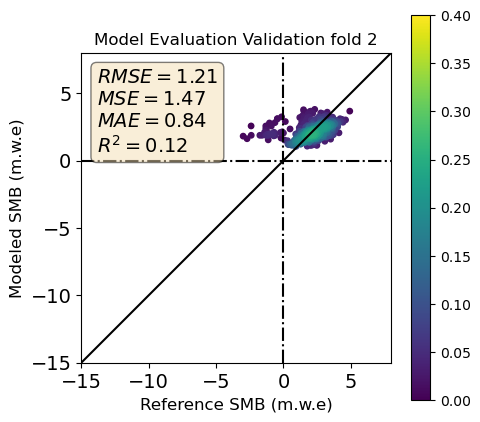

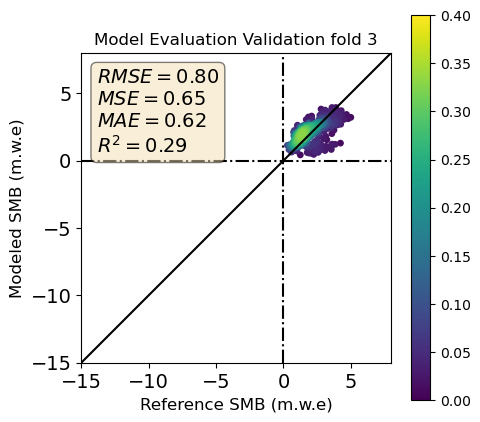

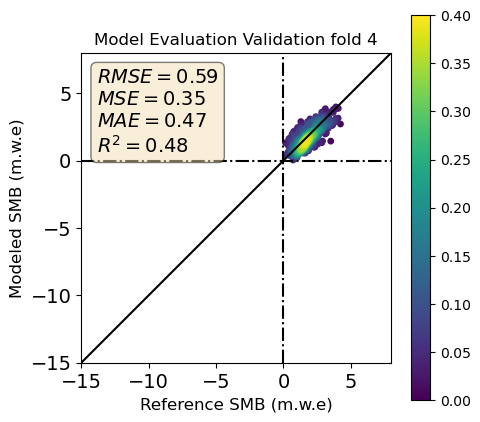

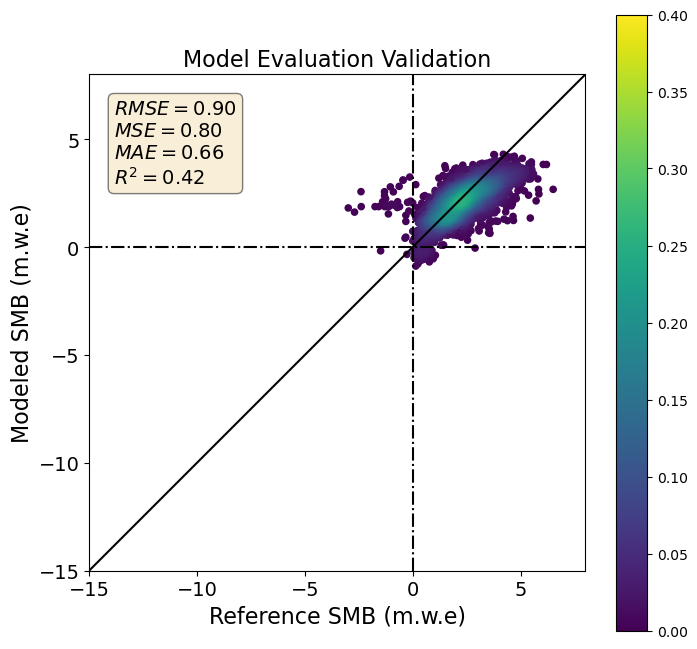

['Models/Final_training/cv_block_glacier_all_climate_winter.pkl']

In [125]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 200, 300, 400, 500], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]}

# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

# Save cv-object
joblib.dump(cv_grid, 'Models/Final_training/cv_block_glacier_all_climate_winter.pkl')

### 4.5 Training with ann+seas, but not using n_months

In [126]:
# Group together outlet glaciers of Folgefonna by renaming BREID to dummy ID 3000
#df_train_all.loc[df_train_all['BREID'].isin([3126, 3127, 3128, 3129])]=3000

# Shuffle df_train, get X and y values
df_train_s = df_train_all.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

# Select features for training
df_train_X_s = df_train_s.drop(['balance','BREID','n_months'], axis=1)

# Select labels for training
df_train_y_s = df_train_s[['balance']]

# Get values
X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

print('Train, fold 0: ', np.unique(gp_s[splits_s[0][0]]))
print('Validation, fold 0: ', np.unique(gp_s[splits_s[0][1]]))
print('Train, fold 1: ', np.unique(gp_s[splits_s[1][0]]))
print('Validation, fold 1: ', np.unique(gp_s[splits_s[1][1]]))
print('Train, fold 2: ', np.unique(gp_s[splits_s[2][0]]))
print('Validation, fold 2: ', np.unique(gp_s[splits_s[2][1]]))
print('Train, fold 3: ', np.unique(gp_s[splits_s[3][0]]))
print('Validation, fold 3: ', np.unique(gp_s[splits_s[3][1]]))
print('Train, fold 4: ', np.unique(gp_s[splits_s[4][0]]))
print('Validation, fold 4: ', np.unique(gp_s[splits_s[4][1]]))

Train, fold 0:  [ 596  675 1092 1094 1144 2078 2148 2474 2514 2597 2743 2772 2968 3126
 3127 3128 3129]
Validation, fold 0:  [2297]
Train, fold 1:  [ 596  675 1092 1094 1144 2148 2297 2474 2514 2597 2743 2772 2968 3126
 3127 3128 3129]
Validation, fold 1:  [2078]
Train, fold 2:  [ 596  675 1144 2078 2148 2297 2597 2743 2772 2968 3126 3127 3128]
Validation, fold 2:  [1092 1094 2474 2514 3129]
Train, fold 3:  [ 596 1092 1094 2078 2148 2297 2474 2514 2968 3126 3127 3129]
Validation, fold 3:  [ 675 1144 2597 2743 2772 3128]
Train, fold 4:  [ 675 1092 1094 1144 2078 2297 2474 2514 2597 2743 2772 3128 3129]
Validation, fold 4:  [ 596 2148 2968 3126 3127]


Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Cross validation score:  -1.351097464594178
Grid search best hyperparameters:  {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 500}
Cross validation scores per fold:  [-1.55523143 -1.48773776 -1.42338469 -1.22905868 -1.06007476]
Mean cross validation score:  -1.351097464594178
Standard deviation:  0.1817439784489964


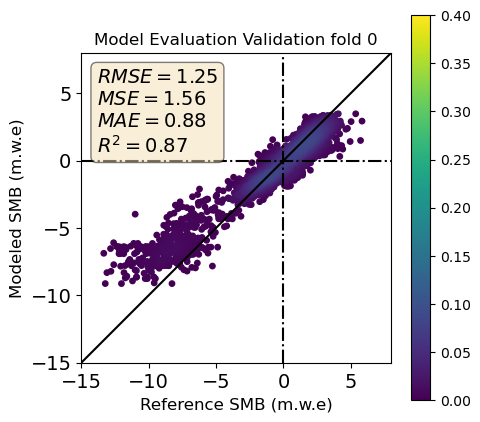

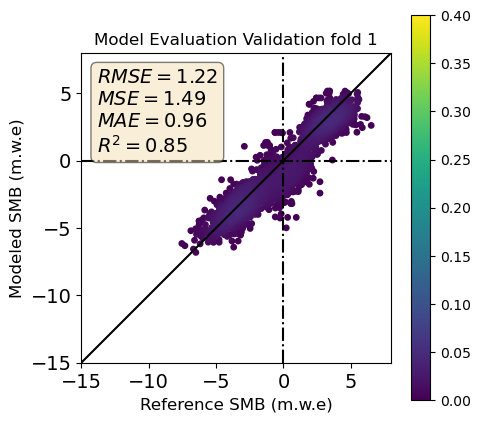

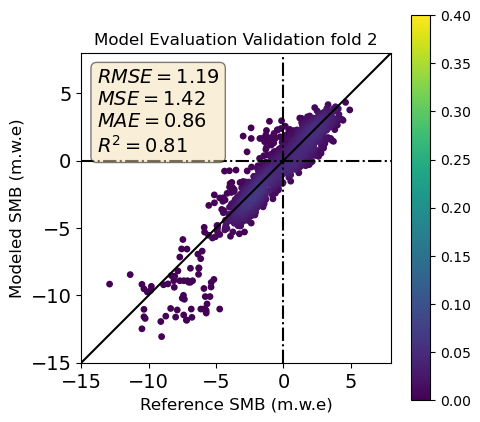

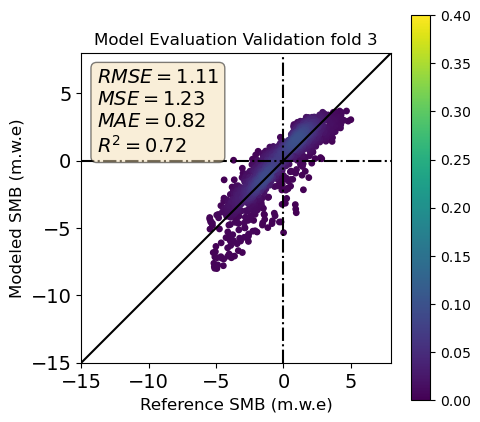

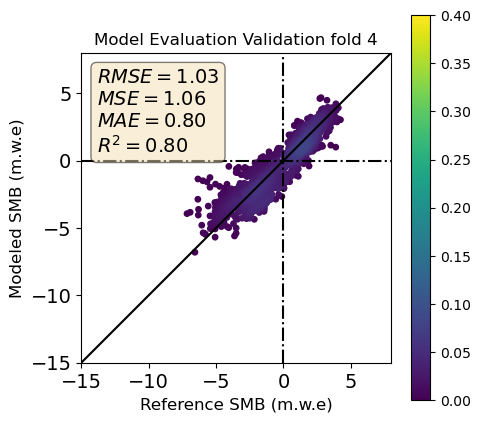

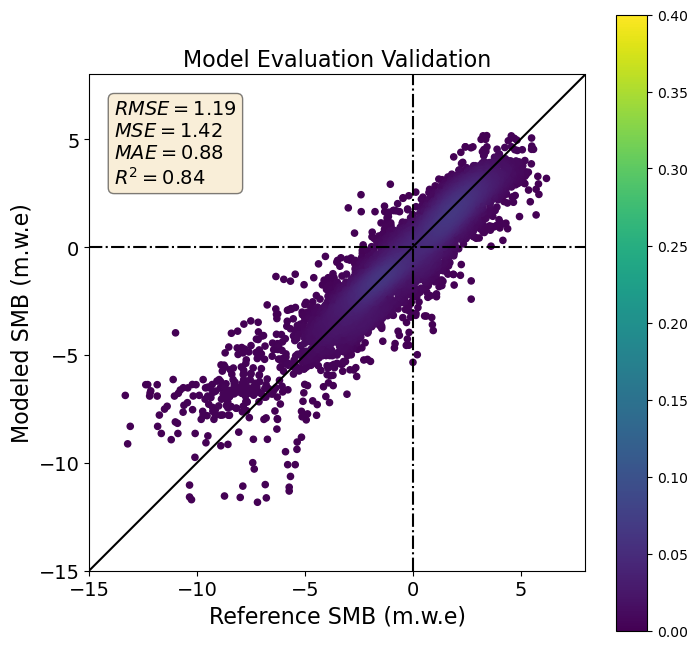

['Models/Final_training/cv_block_glacier_all_climate_ann+seas_wo_nmonths.pkl']

In [127]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 200, 300, 400, 500], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]}

# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

# Save cv-object
joblib.dump(cv_grid, 'Models/Final_training/cv_block_glacier_all_climate_ann+seas_wo_nmonths.pkl')